# Question

<img src="Superbikes-lineup.jpg">

I have previously owned a motorbike, [Suzuki Across], when i was younger. I was forced to sell the bike due to the fact that I couldn't afford to own a car and a bike at the same time. This has now changed, my career has progressed and I am approaching "mid-life", so its a perfect to go through my "mid life crisis" and buy a motorbike 😉.

The motovation for the purchase is purely enjoyment, and will not neccessarily be used for commuting. This means that emotion can easily get in the way of paying a reasonable price for the bike. So I would like to remove the "emotion" from this decision as much as possible.

It is commonly accepted that a used car's sale price is related to a few [features]; The age, Model, Condition, and kilomters on the odometer. *Is this the same for motorbikes?*

There may be a cause to say that bikes could be considered differently as they are predominantly used for enjoyment and not commuting to and from work or down to the shops. Additionally the smaller [learner legal] bikes may retain more value because all new riders are restricted to these types of bikes.

Some questions to ask of the data.

- What features are able to predict the price of a motorbike?
- How much can I save if I buy an older bike?
- How much can I save if there are more kilometers? and how many more kilometers does it take?
- How does the model of the bike affect the sale price?
- Does the location affect the sale price?
- What is the most popular make and model?


[Suzuki Across]:(https://en.wikipedia.org/wiki/Suzuki_Across)
[features]:(https://help.carsales.com.au/hc/en-gb/articles/360015482932-Price-Indicators)
[learner legal]:(https://www.rms.nsw.gov.au/roads/licence/rider/approved-novice-motorcycles.html)

*The ultimate goal is develop an algorithm to predict the price of a motorbike, given a select number of features.
Providing a suggested price to post when a seller is posting a bike on the site.*

In [79]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
#import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')



In [80]:
#Load the data and infer the date format for the date features
file = 'BikeSalesData.csv'

df = pd.read_csv(file, 
                 parse_dates=['First_Seen','Last_Seen','Last Modified','Release Date'], 
                 infer_datetime_format=True, 
                 na_values='-')


## EDA
1. Examine what features are available in the data set.
2. Privide meaningfull definitions of each feature.
3. Determine the different data types
4. Find the features that have missing values, and develop a solution.
    1. Remove the feature all together    
    2. Use Domain knowldge to fill in missing values.
    3. Fill the missing values using statistical techniques (mean, mode, ...)

In [81]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', '1st Gear Ratio', '2nd Gear Ratio',
       '3rd Gear Ratio', '4th Gear Ratio', '5th Gear Ratio', '6th Gear Ratio',
       'ABS', 'ABS Selectable',
       ...
       'Wheel Size Front', 'Wheel Size Rear', 'Wheel Type', 'Wheelbase',
       'Width', 'Width Including Mirrors', 'Winch', 'Windscreen',
       'Windscreen Type', 'iPOD Connectivity'],
      dtype='object', length=238)

In [82]:
df.head()

,Unnamed: 0,Unnamed: 1,1st Gear Ratio,2nd Gear Ratio,3rd Gear Ratio,4th Gear Ratio,5th Gear Ratio,6th Gear Ratio,ABS,ABS Selectable,...,Wheel Size Front,Wheel Size Rear,Wheel Type,Wheelbase,Width,Width Including Mirrors,Winch,Windscreen,Windscreen Type,iPOD Connectivity
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,...,"1.60x21""","1.85x18""","Chrome rim, Heavy duty Spokes, Alloy Hub",1480 mm,860 mm,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,...,"2.75x17""","3.5x17""","Black, T9 Aluminium rims, 5-star spoke",1350 mm,NaN,NaN,NaN,Standard,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observations of the data so far
1. There are a number of features `Unnamed:...` that would appear to be irrelavant and may be a by-product of the scraping process, so we can likely remove these straight away.
2. There are features that will need processing to convert the value into something meaningfull, ie. removing the units from various features.
3. There are some possible duplications of features that may require combination (ie. Carburettor and Carburettor(s) )

### Definitions

`1st Gear Ratio`: The ratio of teeth between the front and rear sockets for 1st gear.

`2nd Gear Ratio`: The ratio of teeth between the front and rear sockets for 2nd gear.

`3rd Gear Ratio`: The ratio of teeth between the front and rear sockets for 3rd gear.

`4th Gear Ratio`: The ratio of teeth between the front and rear sockets for 4th gear.

`5th Gear Ratio`: The ratio of teeth between the front and rear sockets for 5th gear.

`6th Gear Ratio`: The ratio of teeth between the front and rear sockets for 6th gear.

`ABS Selectable`" Ability to turn the vehicle ABS on and off.

`ABS`: Anti-Lock Breaking System, which stops the breaks from locking.

`Acceleration`: The time it takes for the vehicle to reack 100 km/h.

`Adjustable Front Footrests`: Indicates if the front foot rests can be adjusted for a riders height.

`Adjustable Rear Footrests`:Indicates if the rear foot rests can be adjusted for a passengers height.

`Adjustable Seat`: Indicates if the seat has an adjsutable height.

`Airbag(s)`: Indicates if there are air bags fitted to the vehicle.

`Alarm`: Indicates if an alarm is an optional extra or already fitted to the vehicle.

`Australian Capital Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Backrest - Pillion`: Indicates if a backrest is available for a pillion rider.

`Backrest - Rider`: Indicates if a backrest is available for the main rider.

`Battery Description`: Description of the Battery, typically indicating the battery type and ampage.

`Bike`: Description of the vehicle, typically the make and model.

`Bluetooth`: Indicates if bluetooth is available as standard.

`Body`: A description of the body type, ie, sports, touring, scooter, etc ...


`Bore`: The Bore indicates the diamater of the bore cyclinder of the engine.

`Cam Type`: Description of the engine cam type.

`Carburettor(s)`: The number of carburettors.

`Carburettor`: Typically describes the carburettor type, but can also represent the number of carburettors on the vehicle.

`CB Radio`: Indicaets if the vehicle has a CB radio installed.	

`CD Player`:	Indicates if a CD player is available as standard on the vehicle.

`Charge Time (hrs)`: Time to recharge the battery, typically only relevant for electric motors.

`Charging Method`: The method of charging the engine.

`Chassis Description`: Description of the motorvehicle chassis.

`Clutch Diameter`: The diameter of the clutch plate.

`Clutch Type`: Description of the clutch type.

`Colour`: Main colour of the vehicle.

`Compression Ratio`: The proportional ratio of volume inside the combustion chamber from its largest to smallest capacity.

`Configuration`: The configuration of the engine of the vehicle,

`Coolant Capacity`: Capacity of liquid coollant required.

`Cooling`: Cooling system on the vehicle.

`Country of Origin`: Country of manufacture.

`Crash Bar`: Indicates if a crash bar is fitted, preventing the vehicle from damaging the chassis if dropped.

`Cruise Control`: Indicates if cruise control is fitted to the vehicle

`Cup Holders`: Indicates if cup holders are fitted to the vehicle.

`Cylinders`: The number of cyclinders in the engine.

`Decibel Rating`: ???

`Descent Control`: Indicates if the vehicle has descent control as standard.

`Description`: Detailed description of the condition and extras by the owner.

`Drive Type`: Describes the type fo drive system.

`Driven Wheels`: The number of wheels that are driven by the drive system.

`Driver Restraint`: Indicates if a driver restraint is fitted for safety, this is typically only available on 4 wheel drive vehicles.

`Dry Weight`: The weight of the vehicle when no petrol or oil has been added.

`Dual Front Wheels`: ???

`Economy Mode`: Identifies if the vehicle has an economy mode, typically associated with electric vehicles.

`Electronic Power Steering`: Identifies if the vehile has power steering, this is typically associated with 4 wheel vehicles.

`Electronic Suspension Adjustment`: Identifies if the vehicle has electronically controlled adjustable suspension.

`Emission Standard`: Specifies the [European emission standards] acceptable for exhaust emissions of a vehicles sold in the European Union and EEA member states. the standard is generally specific to the year of manufacture, with newer vehicles subject to stricter standards.

`Engine Braking System`: Identifies if the vehicle has a automatic engine cuttoff.

`Engine Capacity`: The size of the engine in cubic centimetres.

`Engine Config`: Description of the engine configuration.

`Engine Description`: Description of the engine size, typically the same as the engine capacity.

`Engine Immobiliser`: Identifies if there is an engine imobiliser installed.

`Engine Stroke`: The number of pistons the engine has.

`Engine Type`: The description of the engine type.

`Engine Voltage`: The Voltage generated by the Engine.

`Exhaust Config`: The configuration of the exhaust system.

`Exhaust Description`: Description of the muffler materials.

`Final Drive Ratio`: The ratio of teeth between the 1st and 6th (last) gear.

`First Service Interval`: The km at which the manufacture recomends the first service take place.

`First_Seen`: The date the advertisement was first seen.

`Frame Design`: The design of the frame structure.

`Frame Material`: The materials used in the frame.

`Front Brake Caliper(s)`: Description of the front brakes callipers.

`Front Brake Description`: Description of the front brakes.

`Front Brake Diameter`: The size of the front brake disc.

`Front Differential Lock`: Identifies if the vehicle has a differential lock system on the front wheels, typically associated with 4 wheeled vehicles.

`Front Payload / Carry Weight`: The payload weight permitted to carry on the front 

`Front Receiver`: ???

`Front Suspension Travel`: The distance the suspension will travel at full compression.

`Front Suspension`: Description of the front sussension system

`Front Tyre`: Description of the front tyre.

`Fuel Reserve Capacity`: Capacity of the reserve tank.

`Fuel Tank Capacity`: Capacity of the fuel tank.

`Fuel Type`: Type of fuel required.

`Gear Change Method`: The method to change gears.

`Gear Number`: The number of gears, exluding neutral.

`Gear Type`: Description of the transmission.

`Glove Box(s)`: Identifies if the vehicle has a glov box, typically associated with four wheeled vehicles.

`GPS Navigation`: Identifies if GPS navigation is available.

`Ground Clearance`: The distance between the ground and the base of the vehicle frame.

`Handlebar Description`: Description of the handlebars.

`Hands Free Ignition`: Identifies if the vehicle has hands free ignition.

`Heated Hand Grips`: Identifies if heated hand grips are available.

`Heated Seats`: Identifies if a heated seat is available.

`Height Including Windscreen`: The height of the vehicle from the ground to the top of the windscreen.

`Height`: The height of the vehicle from the ground to the talles point, excluding the windscreen.

`Ignition Description`: Description of the ignition system.

`Ignition`: Type of ignition system.

`Induction System`: Type of induction system used.

`Instruments / Dash Description`: List of instruments available on the dash board.

`iPOD Connectivity`: Identifies if there is an iPod connection installed on the vehicle.

`Kilometers`: The distance the vehicle has previously travelled.

`KM Range (Full Charge)`: Expected travel distance on a full charge, typically only applies to electric vehicles.

`KM Range (Full Tank)`: Expected travel distance on a full tank.

`Lap Timer`: Indicates if there is a stop watch display on the dash board.

`Last Modified`: The last date the advertisement was modified.

`Last_Seen`: The last date the advertisement was seen.

`Launch Control`: Identifies if electronic launch control is available.

`Lean Angle Left`: The allowable angle the bike is able to lean when turning left.	

`Lean Angle Right`: The allowable angle the bike is able to lean when turning right.

`Learner Approved`: Identifies if the vehicle is learner legal.

`Length`: The length of the vehicle.

`Linked Braking System`: Identifies if the front and rear brakes are linked, and the type of linking.

`Location of Cup Holders`: describes the location of any cupholders.

`Lock Type`: The locking system used on the vehicle.

`Lubrication`: A description of the lubrication system.

`Max Ethanol Blend`: Specifies the maximum ethenol fuel blend acceptable.

`Maximum Power RPM`: Maximum engine revolutions per minute.

`Maximum Power`: Maximum power in kilowatts available to the tyres.

`Maximum Speed`: Maximum speed achievable by the vehicle.

`Maximum Torque RPM`: Maximum tyre revolutions per minute

`Maximum Torque`: Maximum torque in Newton metres, on the wheels.

`MP3 Capatible`: Identifies if MP3 compatibility is available.

`Nerf Bars`: Identifies if a Nerf bar is available.

`Network ID`: An identification code for the advertisement. *This should be a unique identifier*

`New South Wales`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Northern Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Number of Throttle Bodies`: Number of cylinders in the throttle assembly.

`Oil Capacity`: Volume capacity of engine oil.

`Park Brake`: Identifies if a park brake is available.

`Passenger(s) Restraint`: Identifies if a passenger restraint is available, typically only associated with four wheeled vehicles.

`Payload / Carry Weight`: Maximum payload permissible for the vehicle.

`Payment`: Description of secure payment method, if any.

`Postcode`: Postcode the vehicle is kept.

`Price`: The listed price of the vehicle.

`Primary Drive`: Description of the primary drive system.

`Queensland`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Quick Shift`: Identifies if a quick shift is available.

`Rake (Caster Angle)`: The angle from the vertical axis of the front suspension arm of the vehicle.

`RAM Air`: The number of a air scoops to force air to the engine.

`Rear Brake Caliper(s)`: Description of the rear brakes callipers

`Rear Brake Description`: Description of the rear brakes.

`Rear Brake Diameter`: The size of the rear brake disc.

`Rear Cargo Bed Depth`: The depth of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Length`: The length of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Width`: The width of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Differential Lock`: Identifies if the vehicle has a differential lock system on the rear wheels, typically associated with 4 wheeled vehicles.

`Rear Payload / Carry Weight`: The payload weight permitted to carry on the rear. 

`Rear Receiver`: ???

`Rear Suspension Travel`: The distance the suspension will travel at full compression.

`Rear Suspension`: Description of the rear suspension.

`Rear Tyre`: Description of the rear tyre.

`Recommended RON`: Recomended fuel ocatane number.

`Registration Expiry`: Date the registration expires.

`Registration Plate`: Registration identification.

`Registration Status`: The status of the registration.

`Regular Service Interval`: Recomended regular service interval in km.

`Release Date`: Date the vehicle was first released.

`Reverse Gear`: Identifies if the vehicle has reverse gear, typically associated with four wheeled vehicles.

`Ride By Wire`: Identifies if ride-by-wire is available (*The absence of mechanical linkage between accelerator and throttle*).

`Rider / Pillion Communication`: Identifies if internal communication between rider and pillion is available.

`Roadside Assistance`: Identifies if roadside assistance is available.

`Roadworthy/Safety Certificate`: Specifies if a roadworthy certificate is available.

`Roof`: Specifies if the vehicle has a roof available.

`ROPS Approved`: Identifies if an approved Rollover Protection Structure (ROPS) is fitted, typically only available on four wheeled vehicles.

`Saddlebags/Panniers`: Identifies if panniers are available.

`Safety Cut Off Cord`: Identifies if a safety cut off cord is available.

`Seat Description`: Description of the seat characteristics.

`Seat Height Max`: The maximum seat height from the ground.

`Seat Height`: The height of the seat from the ground.

`Seating Capacity`: The standard capacity of the vehicles.

`Seating Position`: Description of the seating position.

`Side Stand Start Inhibitor`: Identifies if a side stand inhibitor is available.

`Side Stand`: Identifies if a side stand is available.

`Skid Plate`: Identifies if a skid plate is available

`Snorkel Air Intake`: Identifies if a snorkel is avalable.

`South Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Spark Plug Description`: Description of the spark plugs fitted.

`Stability Control`: Identifies if stability control is available.

`Starter`: Description of the starter motor.

`State`: The state in which the vehicle is location.

`Steering Damper`: Identifies if a steering damper is available.

`Stock Number`: Stock identification used for dealers.

`Stroke`: The distance a stroke moves in the engine cylinders.

`Suburb`: The suburb the vehicle is kept.

`Swingarm Description`: Description of the swingarm (The material attatching the rear wheel to the bike).

`Swingarm Type`: Description of the type of swingarm.

`Tasmania`:  Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Throttle Bore`: Diametre and description of the throttle cyclinders in the throttle assembly.

`Tilt Steering`: Identifies if tilt steering is available, typically associated with three wheeled vehicles.

`Tool Kit`: Identifies if a tool kit is available.

`Top Box`: Identifies if a top box, sometimes refered to as a helmet box, is available.

`Towing Capability`: Identifies if the vehicle is capable of towing.

`Traction Control Number of Modes`: The number of modes available on traction control.	

`Traction Control Selectable`: Identifies if traction control can be tunred on and off.

`Traction Control`: Identifies if traction control is available.

`Trail`: The distance between the point of the front wheel’s contact with the ground and a line drawn through the axis of the steering head.

`Trailer Payload`: The maximum payload allowable on the trailer.

`Transmission Description`: Description of the transmission

`Turning Radius`: The radius of the turning circle of the vehicle.

`Tyre Pressure Sensors`: Identifies if a tyre pressure sensor is available.

`Unnamed`: Muliple empty features that seems to be a by-product of the scraping process.

`URL`: The URL of the advertisement.

`USB Connectivity`: Identifies if USB connectiveity is available with the vehicle.

`Valve Configuration`: The valvle configuration of the engine.

`Valves Per Cylinder`: The number of valves per cylinder

`Victoria`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`VIN`: The vehicle identification number.

`Warranty in Months from First Registration`: The maximum time period a warranty will apply for.

`Warranty KMs`: The number of kilometres that a warranty will apply for.

`Weight Distribution Front/Rear`: Description of the weight distribution.

`Western Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Wet / Operational Weight`: The weight of the vehicle when filled with oil and fuel.

`Wheel Size Front`: Description of the front wheel size.

`Wheel Size Rear`: Description of the rear wheel size.

`Wheel Type`: Description of the wheel type

`Wheelbase`: The distance between the axis of each wheel.

`Width Including Mirrors`: The width of the vehicle including mirrors

`Width`: The width of the main body of the vehicle.

`Winch`: Identifies if a winch is available.

`Windscreen Type`: Specifies the type of windscreen.

`Windscreen`: Identifies if a windscreen is available.




[European emission standards]:(https://en.wikipedia.org/wiki/European_emission_standards)


### First Pass Cleaning
We can remove the empty features caused by the scraping process.

We should also remove any spaces or joint characters in the column labels.

In [83]:
# Drop known empty features
for col in list(df.columns):
    if 'Unnamed' in col:
        df.drop(col, axis=1, inplace=True)


# I've identified some features that can be dropped manually by looking at the unique values and amount 
# of missing data available in each feature.
manual_drop = ['Emission Standard','Instruments / Dash Description','Payment','Registration Status']
df.drop(manual_drop, axis=1, inplace=True)



In [84]:
# Replace spaces with underscores in the feature list
df.columns = [col.replace('/', '_') for col in df.columns]
df.columns = [col.replace('-', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns = [col.replace('__', '_') for col in df.columns]
# This is used to catch the cases like "Wet / Operational Weight", that would produce 3 '_' characters.
df.columns = [col.replace('__', '_') for col in df.columns] 

### Missing Values
How many missing values do we have?

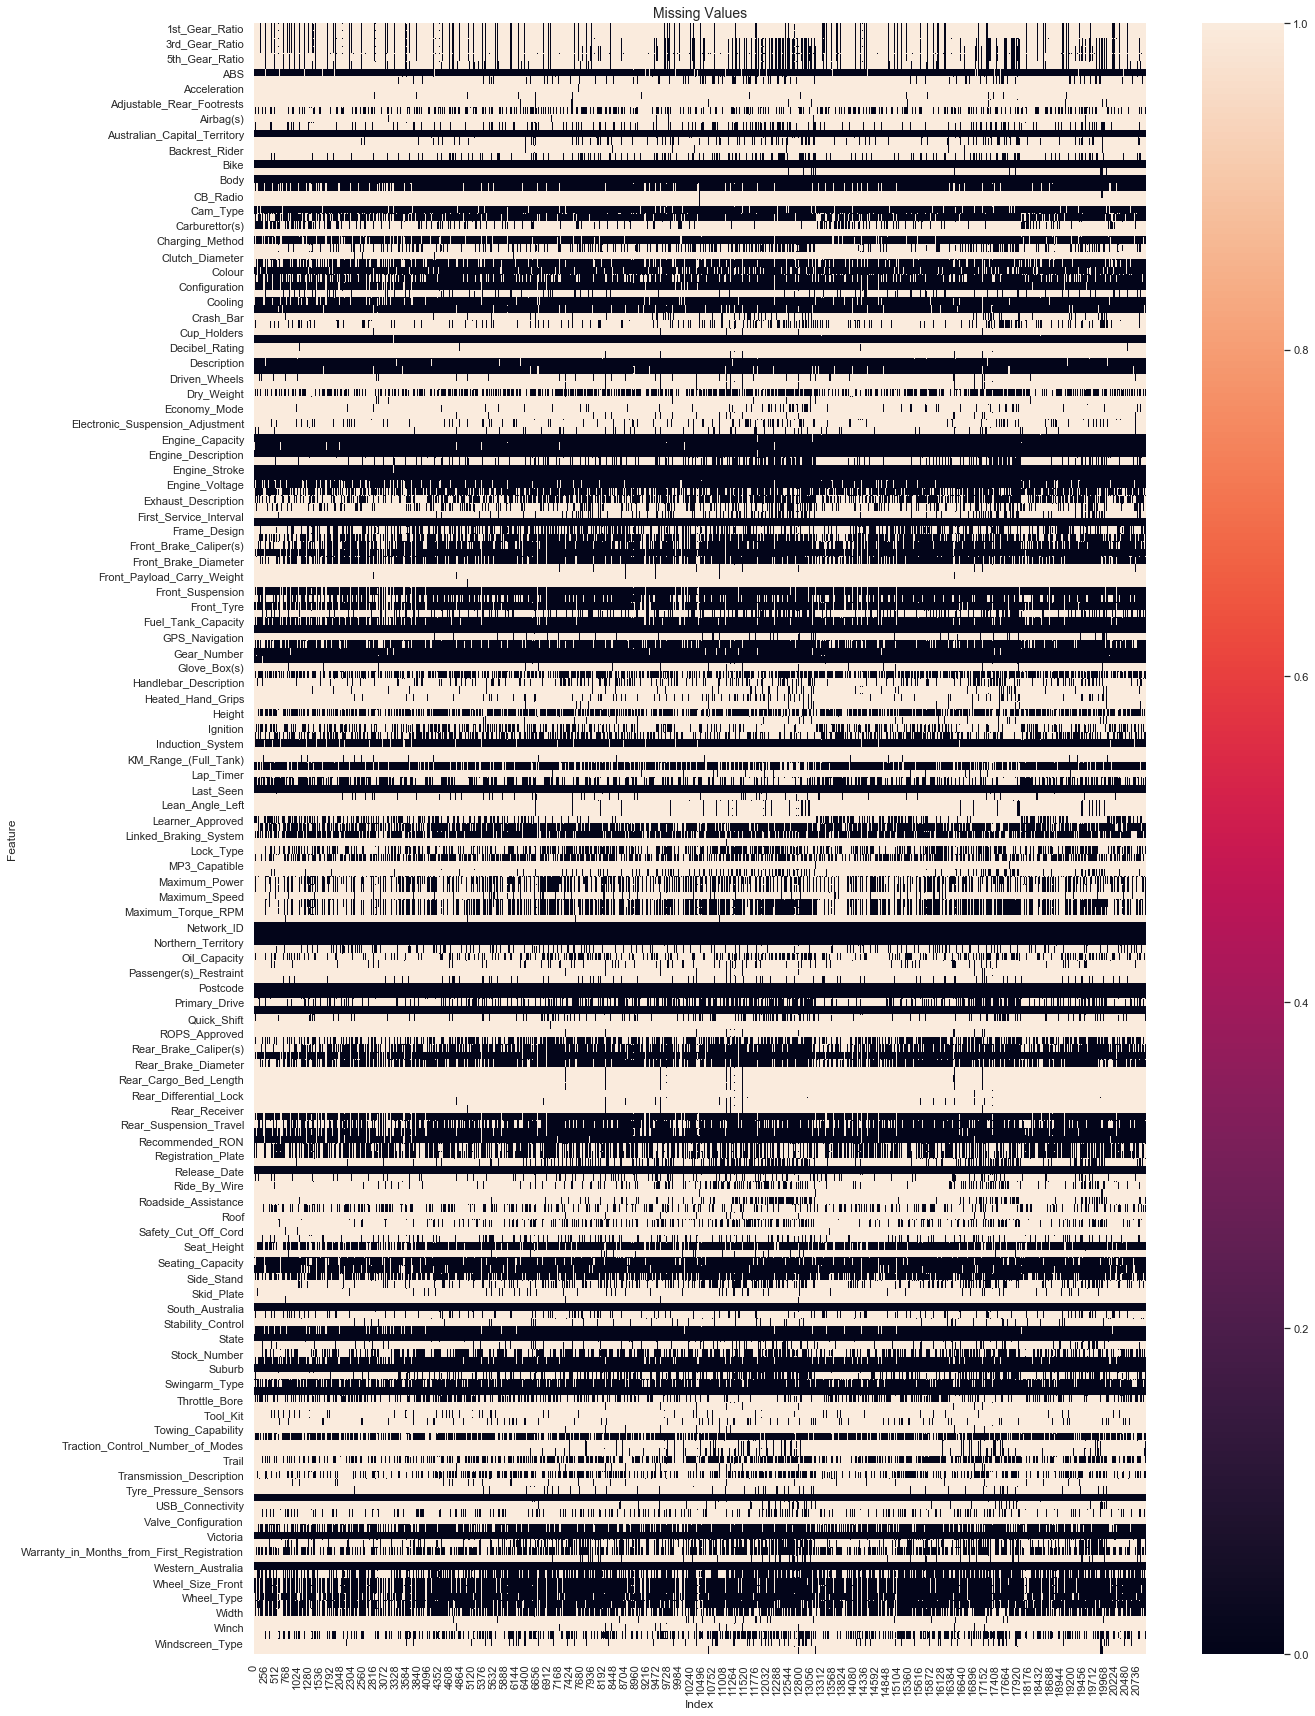

In [85]:
# Display missing values as a heatmap, where the hot part represents missing data
def missing_heatmap(df,size=(20,30)):
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(df.isnull().T, cbar=True, ax=ax)
    plt.ylabel('Feature')
    plt.xlabel('Index')
    plt.title('Missing Values', fontsize=14)
    plt.show()

missing_heatmap(df)
# The pale region indicates missing values.

While The heatmap provides a detailed view of where the missing data actualy is in relation to all other features, it is hard to *see* the detail. This plot gives a good idea of what features are missing a lot of data.

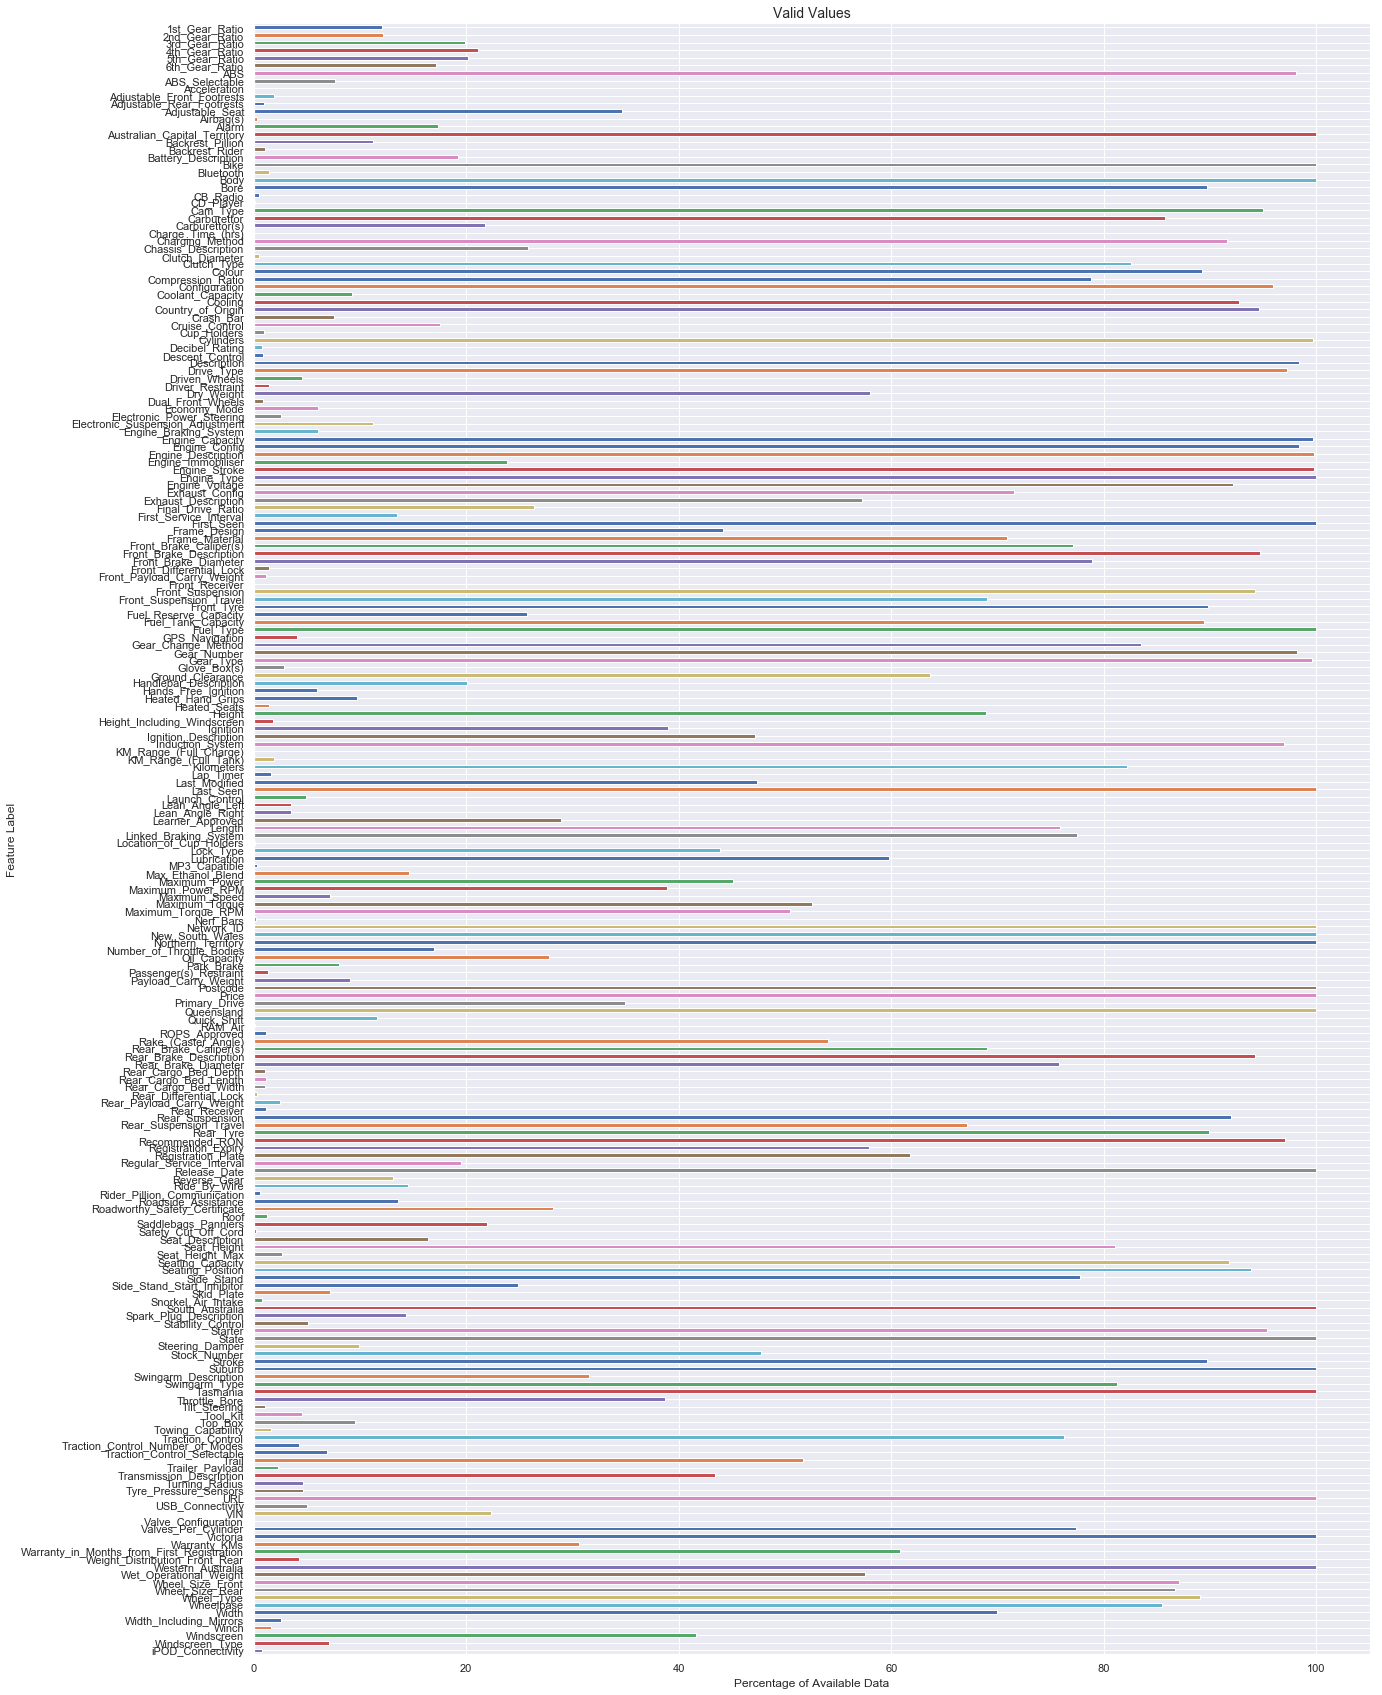

56.974% of data is missing 


In [86]:
# Alternatively display number of valid data as a percentage in a bar chart
def missing_bar(df,figsize=(20,20)):
    total = df.shape[0]
    missing = (total - df.isnull().sum())/total * 100
    missing.plot(kind='barh',figsize=figsize)
    plt.gca().invert_yaxis()
    plt.xlabel('Percentage of Available Data')
    plt.ylabel('Feature Label')
    plt.title('Valid Values', fontsize=14)
    plt.show()

    print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))
    
missing_bar(df, figsize=(20,30))


This seems easier to read than the heat map, so we will use this for bar chart to identify where the missing data is.

#### Dealing with Missing Values
We currently only have ~40% of the potential data that could be available. This would need to be improved if we want to be able to make any predictions on the data. We can accomplish this a number of ways;

1. We can increase this by removing some of the features that have more than 80-90 % of missing data. Imputing data for the missing values in this case will not add any usefullness to the data.

2. We can then look at the features that dont provide any variation, ie. only 1 unique value. 




In [87]:
# Remove all features that have less than 10%  of data.

def remove_columns(df, null_threshold=0.9):
    '''
    Remove the columns that have a significant portion missing.
    
    df:             The dataframe that will be examined
    
    null_threshold: The threshold for permitted missing data;
                    Value must be between 0 and 1
                    (Default: 0.9)
    '''
    
    if ((null_threshold < 0) | (null_threshold >= 1)):
        warning('Threshold value is outside the bounds. Value must be between 0 and 1')
        return df
    
    minimum_null_threshold = null_threshold * df.shape[0]
    remove_list = []

    for col in list(df.columns):
        if (df[col].isnull().sum() > minimum_null_threshold):
            remove_list.append(col)

    print ('Columns before: ',len(df.columns))
    df.drop(remove_list,axis=1, inplace=True)
    print ('Columns after: ',len(df.columns))

    return df
    

In [88]:
# 0.8 - 120 or 112 columns remain
# 0.7 - 105 or 102 columns remain
df = remove_columns(df, null_threshold=0.8)
print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))


Columns before:  214
Columns after:  119
26.909% of data is missing 


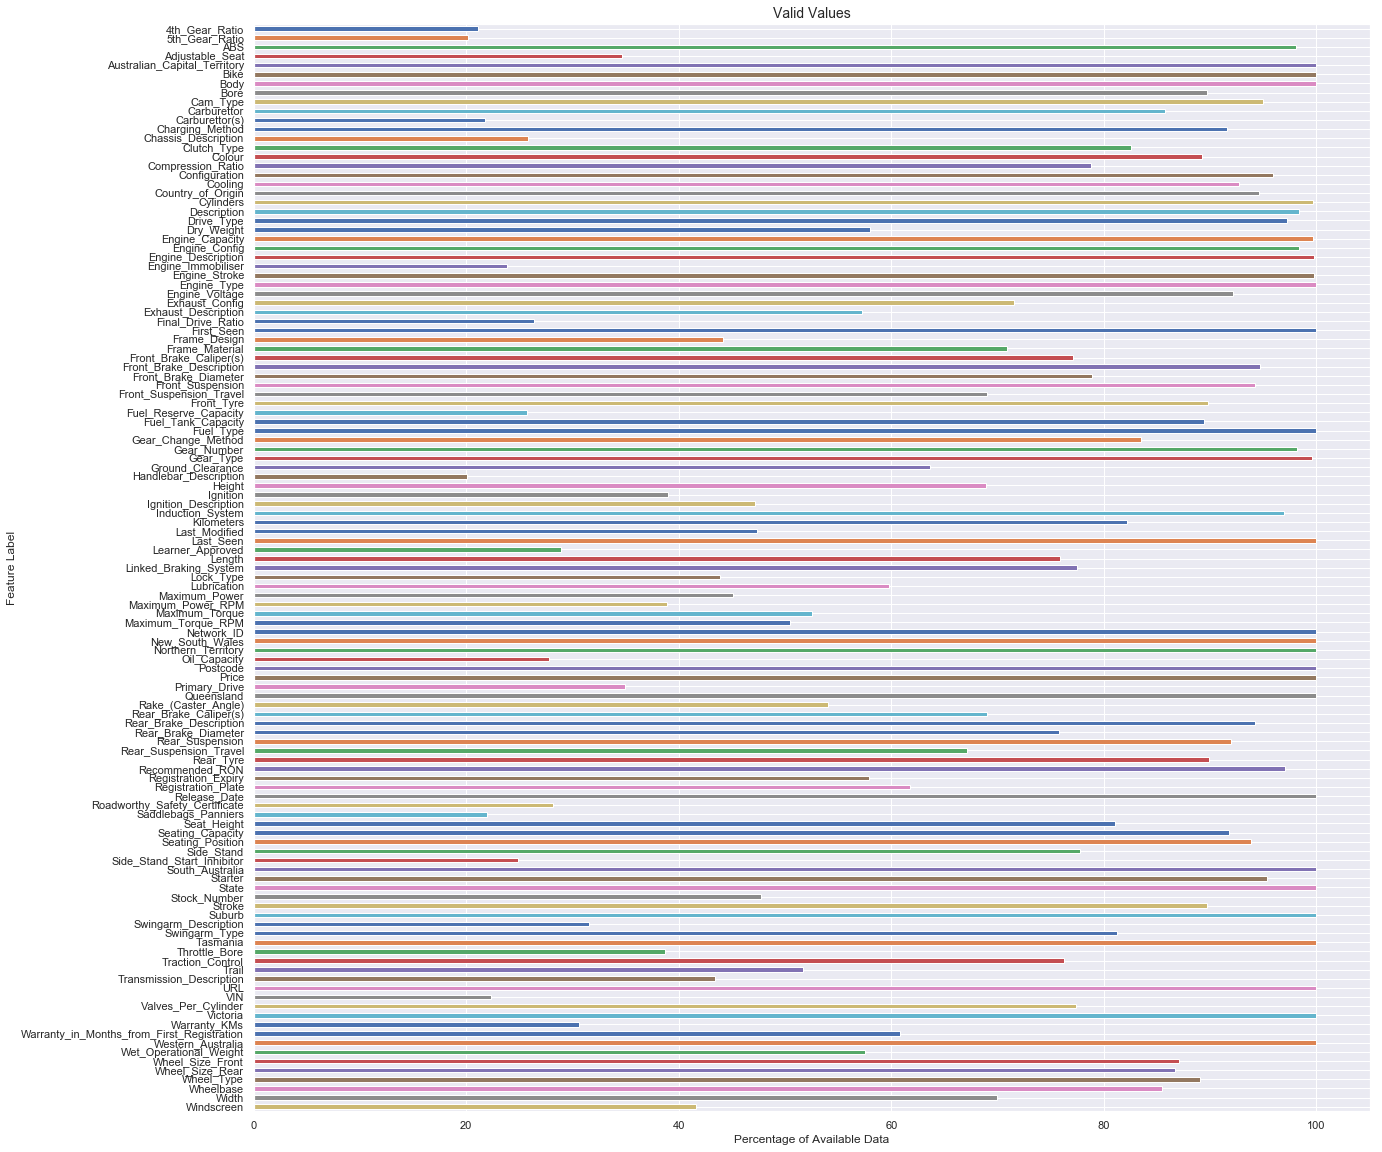

26.909% of data is missing 


In [89]:
missing_bar(df)


We've increased the amount of data that will be useful to over 70%

In [90]:
# Remove the columns where there is only 1 unique value
remove_list = []

for col in list(df.columns):
    if ((len(df[col].unique()) == 1) & (col != 'Last_Seen')):
        remove_list.append(col)
        print (col,df[col].isnull().sum()/df.shape[0])

print ('Columns before: ',len(df.columns))
df.drop(remove_list,axis=1, inplace=True)
print ('Columns after: ',len(df.columns))
    



Australian_Capital_Territory 0.0
New_South_Wales 0.0
Northern_Territory 0.0
Queensland 0.0
South_Australia 0.0
Tasmania 0.0
Victoria 0.0
Western_Australia 0.0
Columns before:  119
Columns after:  111


We will remove some more features using our domain knowledge along with the amount of data available and the variation of each feature.

In [91]:
# These features have been identified as not having much value based on domain knowledge and either
# they dont have many values, or they have too many unique values that could not be grouped to be 
# usefull.
remove = [#'3rd_Gear_Ratio',
          '4th_Gear_Ratio','5th_Gear_Ratio',
          'Chassis_Description', # off home
          'Frame_Design','Swingarm_Description','Lubrication',
          'Engine_Capacity','Front_Tyre','Rear_Tyre','Ignition_Description',
          'Exhaust_Description','Final_Drive_Ratio','Primary_Drive',
          'Handlebar_Description','Throttle_Bore',
          'Transmission_Description','VIN','Wheel_Size_Front','Wheel_Size_Rear']
df.drop(remove, axis=1, inplace=True)


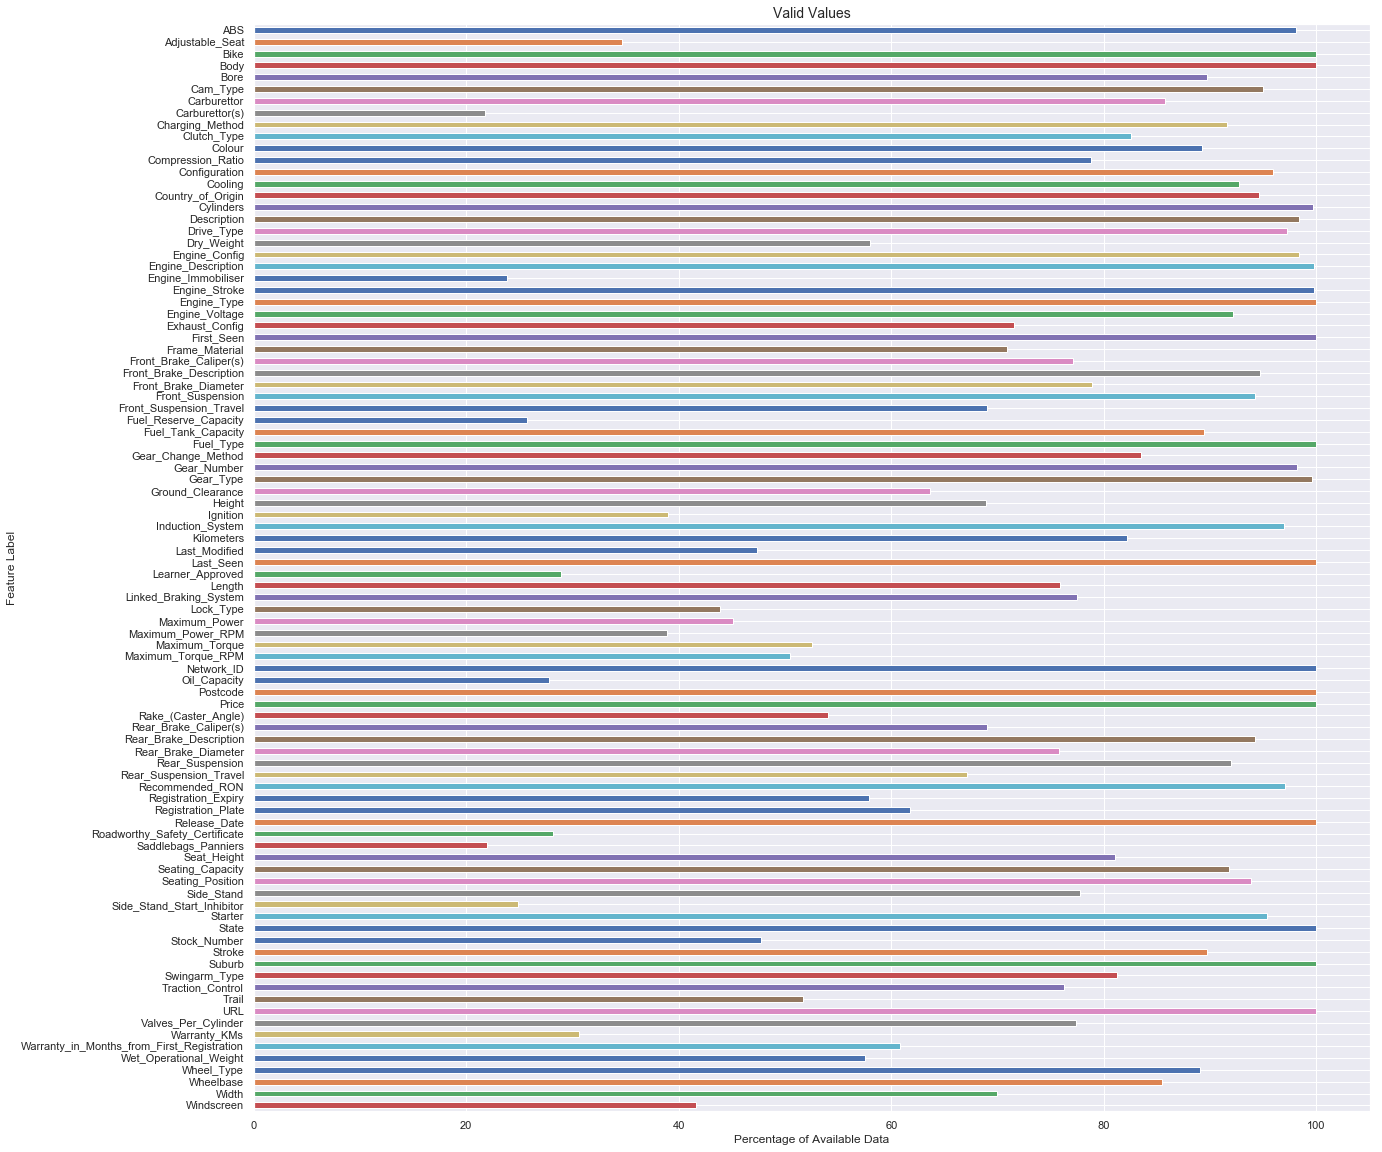

24.436% of data is missing 


In [92]:
    
missing_bar(df)

---
---

### Convert data types
Before we continue with correcting for missing values, we should make sure that all the features are of the correct data type. We will convert the numeric features into numeric datatypes removing any units associated with the values. 

In [93]:
def remove_units(series, units):
    '''Remove the units from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = pd.to_numeric(series.map(lambda x: x.split(units)[0].replace(',','')))
    return series.replace(-1,np.nan)

def remove_delimiters(series):
    '''Remove the known delimiters from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = pd.to_numeric(series.map(lambda x: x.split(':')[0].split('to')[0].split('-')[0].split('±')[0].split('+')[0].split('.')[0]))
    return series.replace(-1,np.nan)

def replace_string(series, string, replace):
    '''Replace specified strings with a number.'''
    series = series.replace(string,replace)
    return pd.to_numeric(series,errors='ignore')

def currency_value(series):
    '''Extract just the currency values from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = pd.to_numeric(series.map(lambda x: x.split('*')[0].replace(',','').replace('$','')),errors='coerce')
    return series.replace(-1,np.nan)
    
def warranty_period(series):
    '''Standardise the values of the warrenty period.'''
    series[series == 'Optional Lifetime'] = '999'
    series[series == 'No Warranty'] = '0'
    series[series.isnull() == True] = '0'
    return pd.to_numeric(series.map(lambda x: x.split()[0]))


In [94]:

# Remove the units
df['Bore'] = remove_units(df['Bore'], 'mm')
df['Dry_Weight'] = remove_units(df['Dry_Weight'], 'kg')
df['Engine_Voltage'] = remove_units(df['Engine_Voltage'], 'Volt')
df['Front_Brake_Diameter'] = remove_units(df['Front_Brake_Diameter'], 'mm')
df['Front_Suspension_Travel'] = remove_units(df['Front_Suspension_Travel'], 'mm')
df['Fuel_Tank_Capacity'] = remove_units(df['Fuel_Tank_Capacity'], 'L')
df['Fuel_Reserve_Capacity'] = remove_units(df['Fuel_Reserve_Capacity'], 'L') # off home
df['Ground_Clearance'] = remove_units(df['Ground_Clearance'], 'mm')
df['Height'] = remove_units(df['Height'], 'mm')
df['Kilometers'] = remove_units(df['Kilometers'], 'km')
df['Length'] = remove_units(df['Length'], 'mm')
df['Maximum_Power'] = remove_units(df['Maximum_Power'], 'kW')
df['Maximum_Torque'] = remove_units(df['Maximum_Torque'], 'Nm')
df['Oil_Capacity'] = remove_units(df['Oil_Capacity'], 'L')
df['Price'] = currency_value(df['Price'])
df['Rake_(Caster_Angle)'] = remove_units(df['Rake_(Caster_Angle)'], 'degrees')
df['Rear_Brake_Diameter'] = remove_units(df['Rear_Brake_Diameter'], 'mm')
df['Rear_Suspension_Travel'] = remove_units(df['Rear_Suspension_Travel'], 'mm')
df['Seat_Height'] = remove_units(df['Seat_Height'], 'mm')
df['Stroke'] = remove_units(df['Stroke'], 'mm')
df['Trail'] = remove_units(df['Trail'], 'mm')
df['Wet_Operational_Weight'] = remove_units(df['Wet_Operational_Weight'], 'kg')
df['Wheelbase'] = remove_units(df['Wheelbase'], 'mm')
df['Width'] = remove_units(df['Width'], 'mm')


# Extract just the number
df['Engine_Stroke'] = df['Engine_Stroke'].str.extract('(\d+)')
df['Warranty_in_Months_from_First_Registration'] = warranty_period(df['Warranty_in_Months_from_First_Registration'])

# Remove characters
df['Compression_Ratio'] = remove_delimiters(df['Compression_Ratio'])

# Replace_string
df['Engine_Stroke'] = replace_string(df['Engine_Stroke'],'Diesel-4','4')
df['Warranty_KMs'] = replace_string(df['Warranty_KMs'],'Unlimited','999999')




In [95]:
# Registration_Expiry
def standardise_registration_expiry(series):
    '''Standardise the registration dates to a common format.'''
    
    # Replace the null values with the first date the advert was seen
    null_mask = series.isnull() == True
    series[null_mask] = 0

    # Define the mask for the entries with 'month' in the value
    month_mask = series.str.contains('Month') == True
    dates = series[month_mask].str.split('-').str[-1].str.lstrip()
    series[month_mask] = pd.to_datetime(dates,format='%B %Y')

    # Replace the '00' centuries with the current.
    series = series.replace('0016','2016',regex=True);
    series = series.replace('0017','2017',regex=True);
    series = series.replace('0018','2018',regex=True);
    series = series.replace('0019','2019',regex=True);

    # Define masks for each type of date format to extract.
    mask = (series.str.split('-').isnull() == False) & \
            (series.str.split('-').str.len() > 1)
    series[mask] = pd.to_datetime(series[mask],format='%b-%y')

    mask = (series.str.split('-').isnull() == False) & \
            (series.str.split('-').str.len() == 1)
    series[mask] = pd.to_datetime(series[mask],format='%B %Y')

    # Convert the numbers into seconds.
    series = pd.to_numeric(series)/1000000000
    series[series < 0] = 0
    
    # Convert all numbers back to a standard date
    return series.map(lambda x: datetime.fromtimestamp(x).strftime("%d/%m/%Y"))
    


df['Registration_Expiry'] = standardise_registration_expiry(df['Registration_Expiry'])


In [96]:
def standardise_release_date(series):
    '''Standardise the date format of the release date of the bike.'''
    
    # Set the NaN values
    series[series == 'nan'] = np.nan
    series[series.isnull() == True] = 'January 2100'

    # Create a mask to filter the short form date
    mask = series.str.split('-').str.len() == 2
    series[mask] = pd.to_datetime(series[mask],format='%b-%y')

    # Create a mask to filter the long form date
    mask = series.str.split().str.len() == 2
    series[mask] = pd.to_datetime(series[mask],format='%B %Y')

    # Convert to seconds
    series = pd.to_numeric(series)/1000000000
    series[series < 0] = 0
    
    # Convert to standard date
    series.map(lambda x: datetime.fromtimestamp(x).strftime("%d/%m/%Y"))
    
    # Return date time series
    #series.dtype
    #series = pd.to_datetime(series,format='%d/%m/%Y')
    return series


df['Release_Date'] = standardise_release_date(df['Release_Date'])

In [97]:
def standardise_country(series):
    '''Standardise the values for the country of origin.'''
    series[series.isnull() == True] = 'NONE'
    ucase = lambda x: x.upper()
    series = series.map(ucase)
    series.replace('CHINA/AUSTRALIA','CHINA')
    
    return series.replace('NONE',np.nan)

    
df['Country_of_Origin'] = standardise_country(df['Country_of_Origin'])

In [98]:
df['Engine_Description'] = pd.to_numeric(df['Engine_Description'],errors='coerce')

In [99]:
# Make sure there is conformity within each column and grouping any related labels together
df['Exhaust_Config'] = df['Exhaust_Config'].str.slice(stop=1)+' into '+df['Exhaust_Config'].str.slice(start=-1)


In [100]:
# Feature engineering 
# We can use the stock number as a proxy to determine if the seller is a private individual or a dealer.
df['Seller'] = 'Private'
df['Seller'][df['Stock_Number'].isnull() == False] = 'Dealer'
df.drop(['Stock_Number'],axis=1, inplace=True)


In [101]:
df.to_csv('BikeSales-Dusty1.csv')

### Imputing missing values
We can use our domain knowledge to impute missing vales. Some missing values we can assume that they are missing because they dont exist for the specified bike, others we will determine using the frequency of existing values or find common values for similar bikes. These will depend on the feature in question.

In [102]:
# We will repalce the missing values in these features with 'No' for not 
# relevant or isn't included in/on the bike.
df['ABS'][df['ABS'].isnull() == True] = 'No'
df['Adjustable_Seat'][df['Adjustable_Seat'].isnull() == True] = 'No'
df['Engine_Immobiliser'][df['Engine_Immobiliser'].isnull() == True] = 'No' # off home
df['Learner_Approved'][df['Learner_Approved'].isnull() == True] = 'No'
df['Linked_Braking_System'][df['Linked_Braking_System'].isnull() == True] = 'No'
df['Warranty_KMs'][df['Warranty_KMs'].isnull() == True] = 'No'
#df['Reverse_Gear'][df['Reverse_Gear'].isnull() == True] = 'No'
df['Roadworthy_Safety_Certificate'][df['Roadworthy_Safety_Certificate'].isnull() == True] = 'No'
df['Saddlebags_Panniers'][df['Saddlebags_Panniers'].isnull() == True] = 'No' # off home
df['Side_Stand_Start_Inhibitor'][df['Side_Stand_Start_Inhibitor'].isnull() == True] = 'No' # off home



In [103]:
df['Colour'][df['Colour'].isnull() == True] = 'Not Specified'
df['Description'][df['Description'].isnull() == True] = 'No Description'
df['Engine_Config'][df['Engine_Config'].isnull() == True] = 'Unknown'
df['Registration_Plate'][df['Registration_Plate'].isnull() == True] = 'None'


#df['Body'][df['Body'].isnull() == True] = df['Body'].mode()[0]
df['Cam_Type'][df['Cam_Type'].isnull() == True] = df['Cam_Type'].mode()[0]
df['Cylinders'][df['Cylinders'].isnull() == True] = int(df['Cylinders'].mode()[0])
df['Engine_Stroke'][df['Engine_Stroke'].isnull() == True] = int(df['Engine_Stroke'].mode()[0])
df['Engine_Type'][df['Engine_Type'].isnull() == True] = df['Engine_Type'].mode()[0]
df['Engine_Voltage'][df['Engine_Voltage'].isnull() == True] = df['Engine_Voltage'].mode()[0]
df['Exhaust_Config'][df['Exhaust_Config'].isnull() == True] = df['Exhaust_Config'].mode()[0]
df['Fuel_Type'][df['Fuel_Type'].isnull() == True] = df['Fuel_Type'].mode()[0]
df['Front_Brake_Caliper(s)'][df['Front_Brake_Caliper(s)'].isnull() == True] = df['Front_Brake_Caliper(s)'].mode()[0]
df['Gear_Change_Method'][df['Gear_Change_Method'].isnull() == True] = df['Gear_Change_Method'].mode()[0]
df['Gear_Number'][df['Gear_Number'].isnull() == True] = int(df['Gear_Number'].mode()[0])
df['Gear_Type'][df['Gear_Type'].isnull() == True] = df['Gear_Type'].mode()[0]
df['Ignition'][df['Ignition'].isnull() == True] = df['Ignition'].mode()[0]
df['Induction_System'][df['Induction_System'].isnull() == True] = df['Induction_System'].mode()[0]
df['Lock_Type'][df['Lock_Type'].isnull() == True] = df['Lock_Type'].mode()[0]
df['Rear_Brake_Caliper(s)'][df['Rear_Brake_Caliper(s)'].isnull() == True] = df['Rear_Brake_Caliper(s)'].mode()[0]
df['Recommended_RON'][df['Recommended_RON'].isnull() == True] = df['Recommended_RON'].mode()[0]
df['Seating_Capacity'][df['Seating_Capacity'].isnull() == True] = df['Seating_Capacity'].mode()[0]
df['Side_Stand'][df['Side_Stand'].isnull() == True] = df['Side_Stand'].mode()[0]
df['Starter'][df['Starter'].isnull() == True] = df['Starter'].mode()[0]
df['Swingarm_Type'][df['Swingarm_Type'].isnull() == True] = df['Swingarm_Type'].mode()[0]
df['Traction_Control'][df['Traction_Control'].isnull() == True] = df['Traction_Control'].mode()[0]
df['Windscreen'][df['Windscreen'].isnull() == True] = df['Windscreen'].mode()[0]


df['Compression_Ratio'][df['Compression_Ratio'].isnull() == True] = df['Compression_Ratio'].mean()
df['Front_Brake_Diameter'][df['Front_Brake_Diameter'].isnull() == True] = df['Front_Brake_Diameter'].mean()
df['Front_Suspension_Travel'][df['Front_Suspension_Travel'].isnull() == True] = df['Front_Suspension_Travel'].mean()
df['Fuel_Reserve_Capacity'][df['Fuel_Reserve_Capacity'].isnull() == True] = df['Fuel_Reserve_Capacity'].mean() # off home
df['Fuel_Tank_Capacity'][df['Fuel_Tank_Capacity'].isnull() == True] = df['Fuel_Tank_Capacity'].mean()
df['Rear_Brake_Diameter'][df['Rear_Brake_Diameter'].isnull() == True] = df['Rear_Brake_Diameter'].mean()
df['Rear_Suspension_Travel'][df['Rear_Suspension_Travel'].isnull() == True] = df['Rear_Suspension_Travel'].mean()
df['Rake_(Caster_Angle)'][df['Rake_(Caster_Angle)'].isnull() == True] = df['Rake_(Caster_Angle)'].mean()



In [104]:
# Missing values can be assumed to be the same value as another feature
df['Last_Modified'][df['Last_Modified'].isnull() == True] = df['First_Seen'][df['Last_Modified'].isnull() == True]


In [105]:
# The information provided in Configuration is broad, but is mostly equivalent to Cooling. 
# So, the cooling information will be extracted to facilitate imputing missing values in the 
# Cooling feature.
# This feature can be droped once the Cooling feature has been imputed.
df['Configuration'] = df['Configuration'].str.lower()
df['Configuration'][df['Configuration'].str.contains('air/oil') == True] = 'Air & Oil'
df['Configuration'][df['Configuration'].str.contains('aikl/oil') == True] = 'Air & Oil'
df['Configuration'][df['Configuration'].str.contains('ai/oil') == True] = 'Air & Oil'
df['Configuration'][df['Configuration'].str.contains('a/oil') == True] = 'Air & Oil'
df['Configuration'][df['Configuration'].str.contains('air/oil/fan') == True] = 'Air/Oil/Fan'
df['Configuration'][df['Configuration'].str.contains('oil/air/fan') == True] = 'Air/Oil/Fan'
df['Configuration'][df['Configuration'].str.contains('oil/fan/air') == True] = 'Air/Oil/Fan'
df['Configuration'][df['Configuration'].str.contains('fan/air/oil') == True] = 'Air/Oil/Fan'
df['Configuration'][df['Configuration'].str.contains('fan/oil/air') == True] = 'Air/Oil/Fan'
df['Configuration'][df['Configuration'].str.contains('liquid/oil') == True] = 'Liquid & Oil'
df['Configuration'][df['Configuration'].str.contains('water/oil') == True] = 'Liquid & Oil'
df['Configuration'][df['Configuration'].str.contains('oil/water') == True] = 'Liquid & Oil'
df['Configuration'][df['Configuration'].str.contains('oil/liquid') == True] = 'Liquid & Oil'
df['Configuration'][df['Configuration'].str.contains('oil') == True] = 'Oil'
df['Configuration'][df['Configuration'].str.contains('liquid/thermo fan') == True] = 'Liquid & Fan'
df['Configuration'][df['Configuration'].str.contains('liquid/fan') == True] = 'Liquid & Fan'
df['Configuration'][df['Configuration'].str.contains('air/fan') == True] = 'Air & Liquid'
df['Configuration'][df['Configuration'].str.contains('fan/air') == True] = 'Air & Liquid'
df['Configuration'][df['Configuration'].str.contains('ait/fan') == True] = 'Air & Liquid'
df['Configuration'][df['Configuration'].str.contains('forced') == True] = 'Forced Air'
df['Configuration'][df['Configuration'].str.contains('air') == True] = 'Air'
df['Configuration'][df['Configuration'].str.contains('liquid') == True] = 'Liquid'
df['Configuration'][df['Configuration'].str.contains('liqued') == True] = 'Liquid'
df['Configuration'][df['Configuration'].str.contains('liqiud') == True] = 'Liquid'
df['Configuration'][df['Configuration'].str.contains('liquied') == True] = 'Liquid'
df['Configuration'][df['Configuration'].str.contains('liqiid') == True] = 'Liquid'
df['Configuration'][df['Configuration'].str.contains('water') == True] = 'Liquid'

possible_values = ['Air', 'Liquid', 'Forced Air', 'Air & Oil', 'Liquid & Oil',
                   'Liquid & Fan', 'Air & Liquid', 'Air/Oil/Fan', 'Turbo Intercooler']

df['Configuration'][(df['Configuration'].isnull() == False) & \
                    (df['Configuration'].isin(possible_values) == False)] = np.nan




In [106]:
# There are a number of features that relate to other features, such as the Bore size,
# and number of Carburettors. Due to this relationship, we can use these relationships to help 
# impute missing values in the related features.

def average_ralation_to_feature(df, groupby, col, precision=3):
    '''
    Find the average value for each group which can be applied to the new column
    
    df: The dataframe.
    
    groupby: The column that has the relation to the feature with missing data.
    
    col: The feature with the missing data.
    
    precision: The precision of the results
    (Default: 3)
    '''
    
    # calcualte the average value for each col
    groups = df.groupby(by=groupby)[col].mean()
    groups = round(groups,precision)
    groups[groups.isnull() == True] = df[col].mean()

    # Populate the missing data with the average value for the corresponding grouped column.
    for item in groups.index:
        if (item in groups.keys()):
            df[col][(df[col].isnull() == True) & (df[groupby] == item)] = groups[item]

    # Replace any remaining NaN values with the feature average.
    df[col][df[col].isnull() == True] = df[col].mean()
    
    
    return df


def mode_ralation_to_feature(df, groupby, col):    
    '''
    Find the mode value for each group which can be applied to the new column
    
    df: The dataframe.
    
    groupby: The column that has the relation to the feature with missing data.
    
    col: The feature with the missing data.
    '''
        
    # calcualte the mode avlue for each column
    groups = df.groupby(by=groupby)[col].apply(lambda x: x.mode())
    
    # Populate the missing data with the average value for the corresponding grouped column.
    for item in groups.index.levels[0]:
        if (item in groups.keys()):
            df[col][(df[col].isnull() == True) & (df[groupby] == item)] = groups[item][0]

    # Replace any remaining NaN values with the most common.
    df[col][df[col].isnull() == True] = df[col].mode()[0]
    
    
    return df

In [107]:

df = average_ralation_to_feature(df, 'Engine_Config', 'Bore', precision=3)
df = average_ralation_to_feature(df, 'Engine_Config', 'Carburettor(s)', precision=0)
df = average_ralation_to_feature(df, 'Engine_Config', 'Engine_Description', precision=-1)
df = average_ralation_to_feature(df, 'Engine_Description', 'Dry_Weight', precision=0)
df = average_ralation_to_feature(df, 'Body', 'Ground_Clearance', precision=0)
df = average_ralation_to_feature(df, 'Body', 'Height', precision=0)
df = average_ralation_to_feature(df, 'Body', 'Length', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Power', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Power_RPM', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Torque', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Torque_RPM', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Oil_Capacity', precision=1)
df = average_ralation_to_feature(df, 'Body', 'Seat_Height', precision=0)
df = average_ralation_to_feature(df, 'Engine_Config', 'Stroke', precision=3)
df = average_ralation_to_feature(df, 'Body', 'Trail', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Wet_Operational_Weight', precision=0)
df = average_ralation_to_feature(df, 'Body', 'Wheelbase', precision=0)
df['Width'][df['Width'] > 1100] = np.nan
df = average_ralation_to_feature(df, 'Engine_Config', 'Width', precision=3)


df = mode_ralation_to_feature(df, 'Engine_Config', 'Charging_Method')
df = mode_ralation_to_feature(df, 'Configuration', 'Cooling')
df = mode_ralation_to_feature(df, 'Body', 'Seating_Position')
df = mode_ralation_to_feature(df, 'Engine_Config', 'Valves_Per_Cylinder')

df.drop(['Configuration'],axis=1,inplace=True)


For some features, the large number of unique values makes it difficult to impute the missing values, because there is too much variation in the feature. We can rectify this by reducing the variation in the feature. We do this by finding similar values and grouping them together.

The following features have been insspected to identify similar types of values that can be grouped together. These groupings are based on domain knowledge and the available data.



In [108]:

df['Carburettor'] = df['Carburettor'].str.lower()

df['Carburettor'][df['Carburettor'].str.contains('cv') == True] = 'constant velocity'
df['Carburettor'][df['Carburettor'].str.contains('constant velocity') == True] = 'constant velocity'
df['Carburettor'][df['Carburettor'].str.contains('carb') == True] = 'carburettor'
df['Carburettor'][df['Carburettor'].str.contains('ddfi') == True] = 'digitalfuel injection'
df['Carburettor'][df['Carburettor'].str.contains('defi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dfi ') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dfsi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dell') == True] = 'dellorto'
df['Carburettor'][df['Carburettor'].str.contains('efi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('multipoint') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('electronic fuel') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('eipi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('electronic intake') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('mpei') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('ei') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('espfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('flat') == True] = 'flatslide'
df['Carburettor'][df['Carburettor'].str.contains('fi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pfi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm-dsfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm-fi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('sfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('yfi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('fuel injected') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('mikumi') == True] = 'mikumi'
df['Carburettor'][df['Carburettor'].str.contains('mikuni') == True] = 'mikumi'
#df['Carburettor'][df['Carburettor'].str.contains('multipoint sequential electronic fuel injection') == True] = 'electronic fuel injection'
#df['Carburettor'][df['Carburettor'].str.contains('multipoint sequential electronic injection') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('programmed') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('sdtv') == True] = 'suzuki dual throttle valve fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('tcbi') == True] = 'digital electronic fuel injection'


possible_values = ['electronic fuel injection','fuel injection','mikuni','constant velocity',
                   'digital fuel injection','dellorto','flatside','carburettor']

df['Carburettor'][(df['Carburettor'].isnull() == False) & (df['Carburettor'].isin(possible_values) == False)] = 'Other'

df['Carburettor'] = df['Carburettor'].str.capitalize()


In [109]:

df['Clutch_Type'] = df['Clutch_Type'].str.lower()

df['Clutch_Type'][df['Clutch_Type'].str.contains('2-disc') == True] = 'twin plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('double disc') == True] = 'twin plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('2-disc') == True] = 'twin plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('7 friction') == True] = '7-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('8-plate') == True] = '8-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('8 plate') == True] = '8-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('10-plate') == True] = '10-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('12-plate') == True] = '12-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('3-plate') == True] = '3-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('5-disc') == True] = '5-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('5-plate') == True] = '5-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('6-plate') == True] = '6-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('7-plate') == True] = '7-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('7 plate') == True] = '7-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('7-disc') == True] = '7-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('8-plate') == True] = '8-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('9-plate') == True] = '9-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('9 plate') == True] = '9-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('single') == True] = 'single plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('twin') == True] = 'twin plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('dual') == True] = 'twin plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('triple') == True] = '3-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('aptc') == True] = 'adler power torque clutch'
df['Clutch_Type'][df['Clutch_Type'].str.contains('anti-hop') == True] = 'anti-hop'
df['Clutch_Type'][df['Clutch_Type'].str.contains('antii-hop') == True] = 'anti-hop'
df['Clutch_Type'][df['Clutch_Type'].str.contains('automatic') == True] = 'automatic'
df['Clutch_Type'][df['Clutch_Type'].str.contains('centrifugal') == True] = 'centrifugal'
df['Clutch_Type'][df['Clutch_Type'].str.contains('mulit') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('disc') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('plate') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('multiple') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('electronically') == True] = 'electronically controlled'
df['Clutch_Type'][df['Clutch_Type'].str.contains('hydraulic') == True] = 'hydraulically operated'
df['Clutch_Type'][df['Clutch_Type'].str.contains('slipper') == True] = 'slipper'
df['Clutch_Type'][df['Clutch_Type'].str.contains('ultramatic') == True] = 'ultramatic'
df['Clutch_Type'][df['Clutch_Type'].str.contains('wet') == True] = 'wet'
df['Clutch_Type'][df['Clutch_Type'].str.contains('dry') == True] = 'dry'
df['Clutch_Type'][df['Clutch_Type'].str.contains('clutchless') == True] = 'clutchless'
df['Clutch_Type'][df['Clutch_Type'].str.contains('mechanical') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('foot') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('cable') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('manual') == True] = 'mechanical'

possible_values = ['multi plate', 'automatic', 'centrifugal', 'wet', 'dry', 'slipper', 
                   'hydraulically operated', 'adler power torque clutch', 'anti-hop', 
                   'clutchless', 'electronically controlled', 'mechanical']

df['Clutch_Type'][(df['Clutch_Type'].isnull() == False) & (df['Clutch_Type'].isin(possible_values) == False)] = 'Other'


df['Clutch_Type'] = df['Clutch_Type'].str.capitalize()

In [110]:
df['Drive_Type'][df['Drive_Type'].str.contains('Belt') == True] = 'Belt'
df['Drive_Type'][df['Drive_Type'].str.contains('Chain') == True] = 'Chain'
df['Drive_Type'][df['Drive_Type'].str.contains('Shaft') == True] = 'Shaft'


In [111]:
# df['Frame_Design'][df['Frame_Design'].str.contains('25crmo4') == True] = 'chrome'

# df['Frame_Design'] = df['Frame_Design'].str.lower()  

# df['Frame_Design'][df['Frame_Design'].str.contains('pressed') == True] = 'Pressed'

# df['Frame_Design'][df['Frame_Design'].str.contains('backbone') == True] = 'Backbone'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin spine') == True] = 'Backbone'
# df['Frame_Design'][df['Frame_Design'].str.contains('under bone') == True] = 'Backbone'
# df['Frame_Design'][df['Frame_Design'].str.contains('underbone') == True] = 'Backbone'

# df['Frame_Design'][df['Frame_Design'].str.contains('single downtube') == True] = 'Single cradle'
# df['Frame_Design'][df['Frame_Design'].str.contains('single cradle') == True] = 'Single cradle'
# df['Frame_Design'][df['Frame_Design'].str.contains('single spar') == True] = 'Single cradle'
# df['Frame_Design'][df['Frame_Design'].str.contains('single tube') == True] = 'Single cradle'

# df['Frame_Design'][df['Frame_Design'].str.contains('half-duplex') == True] = 'Half-duplex cradle'

# df['Frame_Design'][df['Frame_Design'].str.contains('bilateral beam') == True] = 'Bilateral beam'

# df['Frame_Design'][df['Frame_Design'].str.contains('perimeter') == True] = 'Perimeter'
# df['Frame_Design'][df['Frame_Design'].str.contains('perimetre') == True] = 'Perimeter'

# df['Frame_Design'][df['Frame_Design'].str.contains('duplex cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('duplex') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('dual beam') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('full cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('central') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('closed double cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('semi double') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('semi-double') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('single beam; double') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('double loop') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('double-cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('double cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('duplex cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('tubular') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin cradle') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin spar') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin-spar') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin tube') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin-tube') == True] = 'Full duplex beam'
# df['Frame_Design'][df['Frame_Design'].str.contains('twin beam') == True] = 'Full duplex beam'

# df['Frame_Design'][df['Frame_Design'].str.contains('monocoque') == True] = 'Monocoque'

# df['Frame_Design'][df['Frame_Design'].str.contains('semi-monocoque') == True] = 'Semi-monocoque'

# df['Frame_Design'][df['Frame_Design'].str.contains('trellis') == True] = 'Trellis'
# df['Frame_Design'][df['Frame_Design'].str.contains('trell') == True] = 'Trellis'
# df['Frame_Design'][df['Frame_Design'].str.contains('trestel') == True] = 'Trellis'
# df['Frame_Design'][df['Frame_Design'].str.contains('trestle') == True] = 'Trellis'
# df['Frame_Design'][df['Frame_Design'].str.contains('truss') == True] = 'Trellis'
# df['Frame_Design'][df['Frame_Design'].str.contains('diamon') == True] = 'Trellis'

# df['Frame_Design'][df['Frame_Design'].str.contains('bridge') == True] = 'Bridge type'
# df['Frame_Design'][df['Frame_Design'].str.contains('bridging') == True] = 'Bridge type'

# df['Frame_Design'][df['Frame_Design'].str.contains('ladder') == True] = 'Lattice'

# df['Frame_Design'][df['Frame_Design'].str.contains('cradle') == True] = 'Single cradle'

# df['Frame_Design'][df['Frame_Design'].str.contains('crome') == True] = 'chrome'

# df['Frame_Design'] = df['Frame_Design'].str.capitalize()


In [112]:
def group_brake_description(df, feature):
    ''' Group the similar types of brake descriptions using common terms. '''
    
    df[feature] = df[feature].str.lower()
    
    df[feature][df[feature].str.contains('hydraulic') == True] = 'Hydraulic'
    df[feature][df[feature].str.contains('calliper') == True] = 'Calliper'
    df[feature][df[feature].str.contains('disc') == True] = 'Disc'
    df[feature][df[feature].str.contains('disk') == True] = 'Disc'
    df[feature][df[feature].str.contains('rotor') == True] = 'Disc'
    df[feature][df[feature].str.contains('piston') == True] = 'Piston'
    df[feature][df[feature].str.contains('drum') == True] = 'Drum'
    df[feature][df[feature].str.contains('shoe') == True] = 'Drum'
    df[feature][df[feature].str.contains('expanding') == True] = 'Expanding'

    possible_values = ['Hydraulic','Calliper','Disc','Drum','Piston','Expanding']

    df[feature][(df[feature].isnull() == False) & (df[feature].isin(possible_values) == False)] = 'Other'
    
    
    return df[feature]


In [113]:
df['Front_Brake_Description'] = group_brake_description(df,'Front_Brake_Description')
df['Rear_Brake_Description'] = group_brake_description(df,'Rear_Brake_Description')


In [114]:
def group_suspension(df,feature):
    ''' Group the similar types of suspensions using common terms. '''
    
    df[feature] = df[feature].str.lower()
        
    df[feature][df[feature].str.contains('hydraulic') == True] = 'Hydraulic'
    df[feature][df[feature].str.contains('telesc') == True] = 'Telescopic'
    df[feature][df[feature].str.contains('inverted') == True] = 'Inverted'
    df[feature][df[feature].str.contains('spring') == True] = 'Spring'
    df[feature][df[feature].str.contains('upside') == True] = 'Upside Down'
    df[feature][df[feature].str.contains('up side') == True] = 'Upside Down'
    df[feature][df[feature].str.contains('shock') == True] = 'Shock'


    df[feature][df[feature].str.contains('Front Suspension') == True] = np.nan
    df[feature][df[feature].str.contains('Nil') == True] = np.nan


    possible_values = ['Telescopic','Inverted','Upside Down','Hydraulic','Shock','Spring']

    df[feature][(df[feature].isnull() == False) & (df[feature].isin(possible_values) == False)] = 'Other'

    return df[feature]



In [115]:
df['Front_Suspension'] = group_suspension(df,'Front_Suspension')
df['Rear_Suspension'] = group_suspension(df,'Rear_Suspension')



In [116]:
def group_material(df,feature):
    ''' Group the similar types of materials used, using common terms. '''
    
    df[feature] = df[feature].str.lower()
    
    df[feature][df[feature].str.contains('chrom') == True] = 'Chrome'
    df[feature][df[feature].str.contains('steel') == True] = 'Steel'
    df[feature][df[feature].str.contains('aum') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('alum') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('cast') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('magnesium') == True] = 'Magnesium'
    df[feature][df[feature].str.contains('titanium') == True] = 'Titanium'
    df[feature][df[feature].str.contains('alloy') == True] = 'Alloy'
    df[feature][df[feature].str.contains('composite') == True] = 'Composite'
    df[feature][df[feature].str.contains('monolever') == True] = 'Monolever'
    df[feature][df[feature].str.contains('asymmetric') == True] = 'Asymmetric'
    df[feature][df[feature].str.contains('carbon') == True] = 'Carbon Fibre'

    possible_values = ['Chrome','Steel','Aluminium','Magnesium','Titanium','Alloy',
                       'Composite','Monolever','Asymmetric','Carbon Fibre']

    df[feature][(df[feature].isnull() == False) & (df[feature].isin(possible_values) == False)] = 'Other'

    return df[feature]

In [117]:
df['Frame_Material'] = group_material(df,'Frame_Material')
#df['Swingarm_Description'] = group_material(df,'Swingarm_Description')


In [118]:
df['Wheel_Type'] = df['Wheel_Type'].str.lower()

df['Wheel_Type'][df['Wheel_Type'].str.contains('36') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('28') == True] = '28-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('25') == True] = '25-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('24') == True] = '24-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('14') == True] = '14-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('13') == True] = '13-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('12') == True] = '12-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('10') == True] = '10-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('9') == True] = '9-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('8') == True] = '8-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('7') == True] = '7-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('6') == True] = '6-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('5') == True] = '5-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('4') == True] = '4-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('3') == True] = 'Y-Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('muilti') == True] = 'Multi Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('multi') == True] = 'Multi Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('multti') == True] = 'Multi Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('star') == True] = 'Star'
df['Wheel_Type'][df['Wheel_Type'].str.contains('laced') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('cross') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y-shape') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y shape') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y-spoke') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y spoke') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('star') == True] = '5-Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('wire') == True] = 'Wire Spoke'

df['Wheel_Type'][df['Wheel_Type'].str.contains('aum') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alum') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('cast') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alloy') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('chrom') == True] = 'Chrome'
df['Wheel_Type'][df['Wheel_Type'].str.contains('steel') == True] = 'Steel'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alumite') == True] = 'Alumite Rims'
df['Wheel_Type'][df['Wheel_Type'].str.contains('carbon') == True] = 'Carbon Fibre'
df['Wheel_Type'][df['Wheel_Type'].str.contains('custom') == True] = 'Custom'


possible_values = ['Laced','28-Spoke','25-Spoke','24-Spoke','14-Spoke','13-Spoke','12-Spoke','10-Spoke',
                   '9-Spoke','8-Spoke','7-Spoke','6-Spoke','5-Spoke','4-Spoke','Y-Shape','Multi Spoke',
                   'Wire Spoke','Aluminium','Chrome','Steel','Alumite Rims','Carbon Fibre','Custom']
    
df['Wheel_Type'][(df['Wheel_Type'].isnull() == False) & (df['Wheel_Type'].isin(possible_values) == False)] = 'Other'

In [119]:

# df['Lubrication'][df['Lubrication'].str.contains('Wet Sump') == True] = 'Wet Sump'
# df['Lubrication'][df['Lubrication'].str.contains('Semi-Dry') == True] = 'Semi Dry Sump'
# df['Lubrication'][df['Lubrication'].str.contains('Semi Dry') == True] = 'Semi Dry Sump'
# df['Lubrication'][df['Lubrication'].str.contains('Dry Sump') == True] = 'Dry Sump'
# df['Lubrication'][df['Lubrication'].str.contains('Auto Mix') == True] = 'Auto Mix'
# df['Lubrication'][df['Lubrication'].str.contains('Premix') == True] = 'Auto Mix'
# df['Lubrication'][df['Lubrication'].str.contains('Injection') == True] = 'Auto Mix'
# df['Lubrication'][df['Lubrication'].str.contains('Pressure') == True] = 'Pressure'
    
    
# possible_values = ['Wet Sump','Semi Dry Sump','Dry Sump','Auto Mix','Pressure']
    
# df['Lubrication'][(df['Lubrication'].isnull() == False) & (df['Lubrication'].isin(possible_values) == False)] = 'Other'

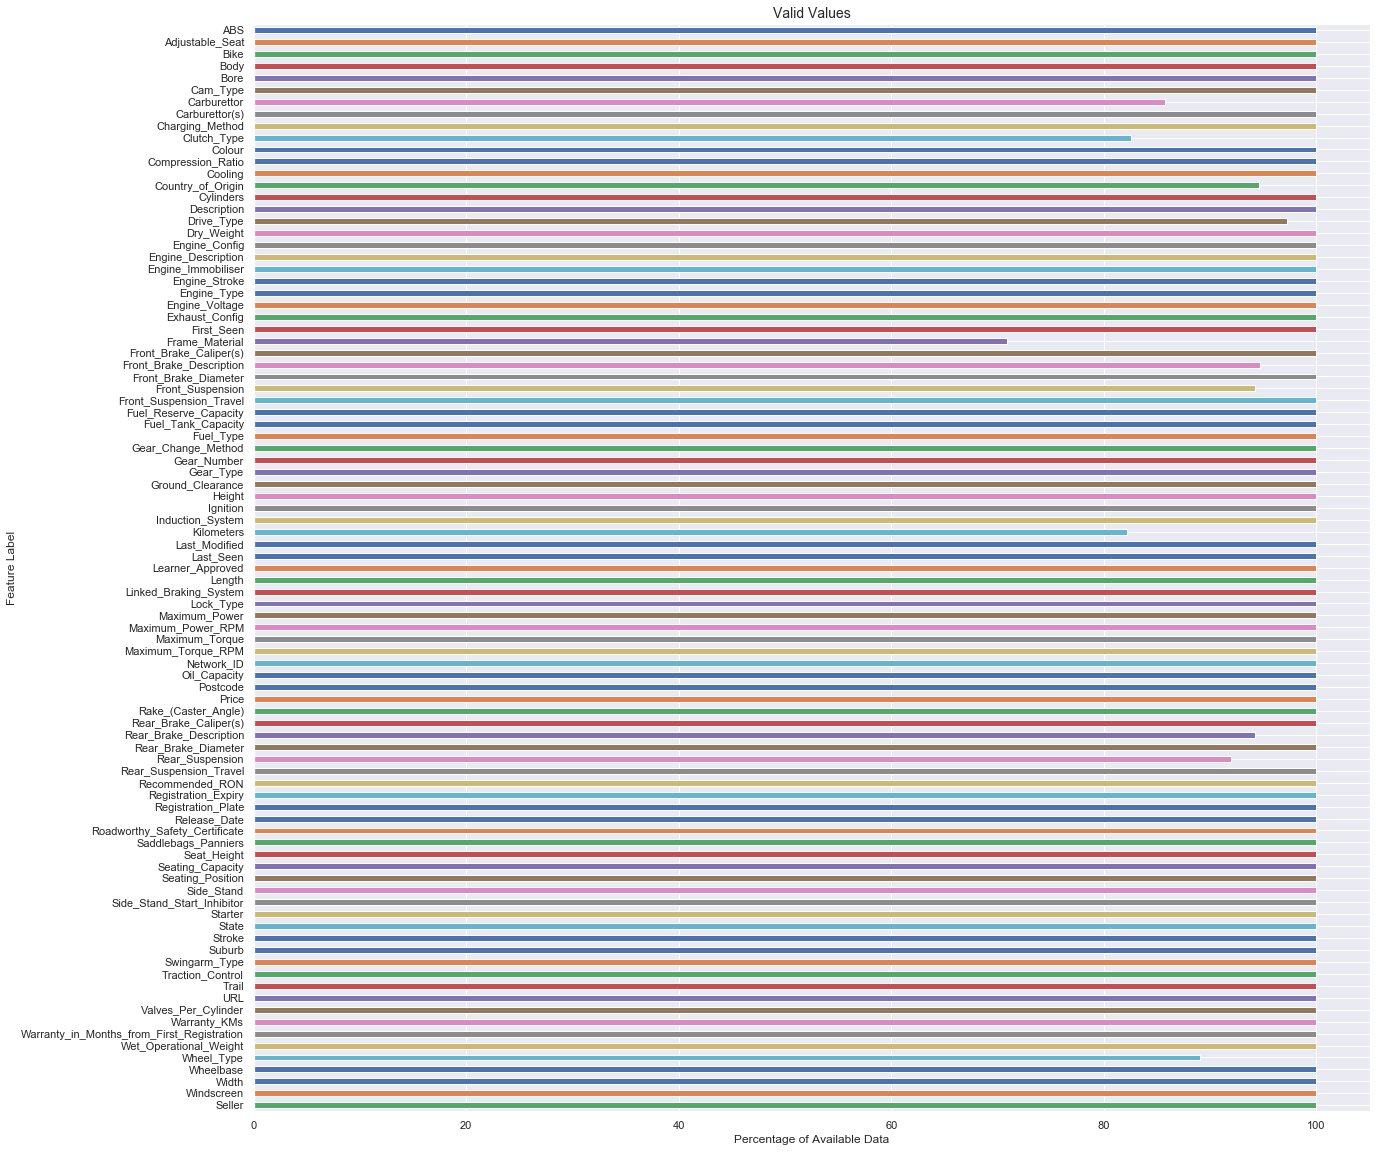

1.349% of data is missing 


In [120]:
missing_bar(df)

In [121]:
df.to_csv('BikeSales-Dusty2.csv')

---
---

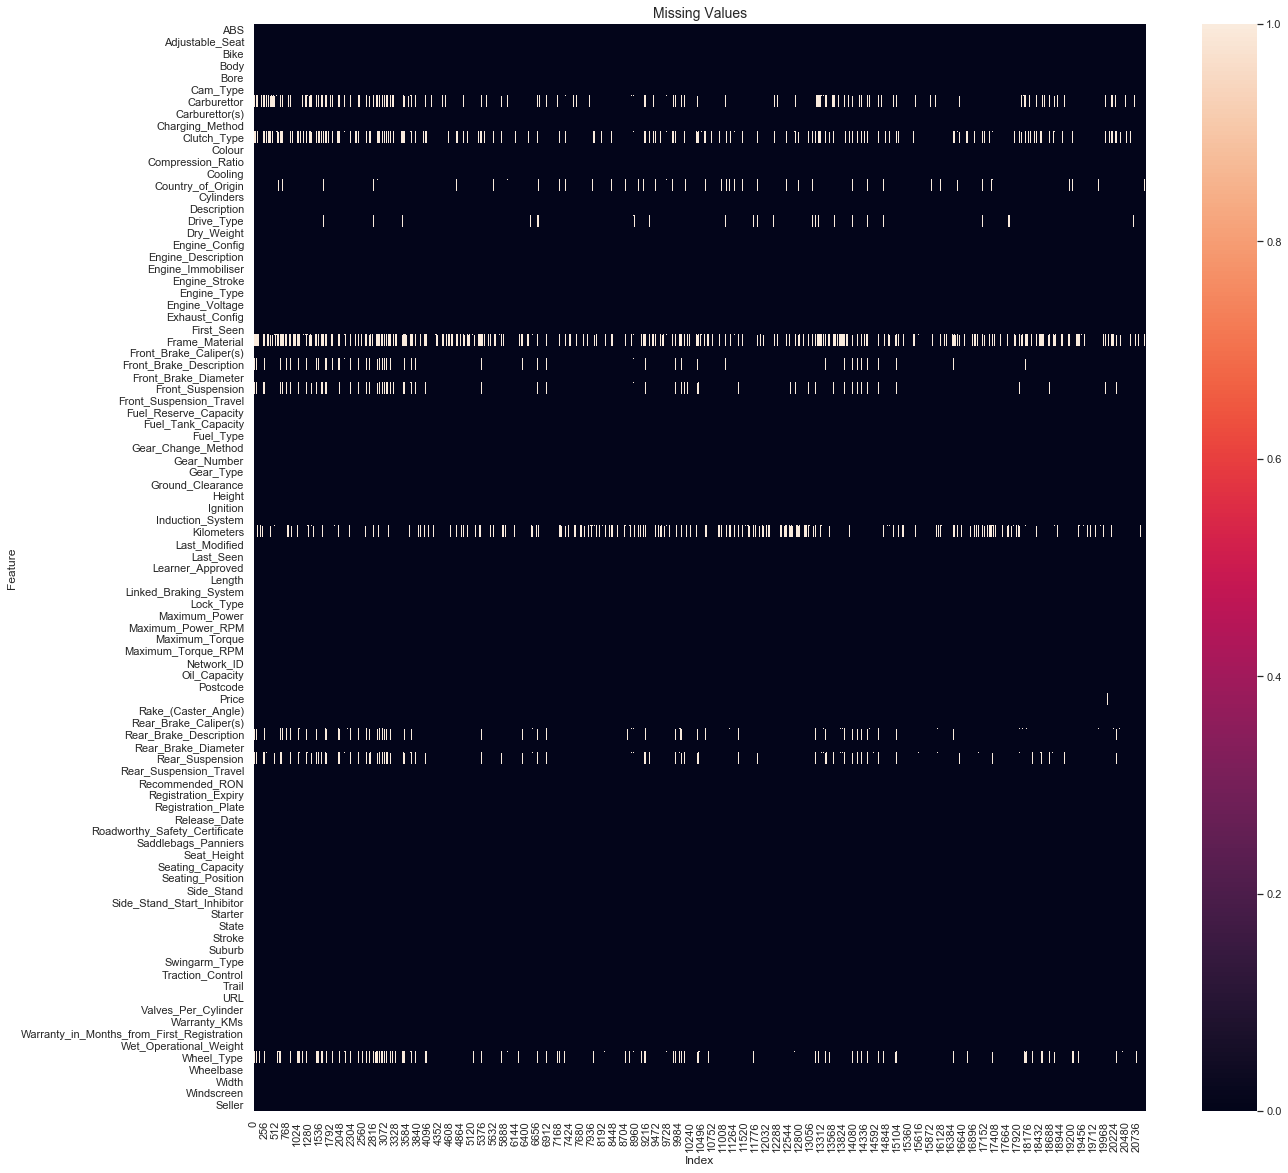

In [122]:
missing_heatmap(df,(20,20))

In [123]:
features = []
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print (col,df[col].dtype,df[col].isnull().sum()/df.shape[0]*100)
        features.append(col)
    
#df.isnull().sum()

Body object 0.019077598130395383
Carburettor object 14.231888205274956
Clutch_Type object 17.42738589211618
Country_of_Origin object 5.422807268564888
Drive_Type object 2.780559927505127
Frame_Material object 29.131492345113752
Front_Brake_Description object 5.279725282586922
Front_Suspension object 5.780512233509802
Kilometers float64 17.84709305098488
Price float64 0.042924595793389614
Rear_Brake_Description object 5.7852816330424
Rear_Suspension object 8.031668812896456
Wheel_Type object 10.936233128249153


In [43]:
         
group_then_impute = ['Carburettor','Clutch_Type','Configuration','Drive_Type','Frame_Design','Frame_Material',
                     'Front_Brake_Description','Front_Suspension',
                     'Rear_Brake_Description','Rear_Suspension',
                     'Swingarm_Description','Wheel_Type','Lubrication','Body','Kilometres'
    
]

random_forest = ['Body','Kilometers'
    
]

# Kilometers : if dealer bike, then 0, else average kilometres for the age of the bike

# idx = (df['Bike'][df['Body'].isnull() == True].str.contains('Competition') == True).index
# df['Body'].iloc[idx] = 'Competition'

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


In [127]:
test = df.copy(deep=True)
test.dropna(inplace=True)
col = 'Body'
features = list(set(test.columns) - set([col]))
target = col

subset = test[test[col].isnull() == False]


X = subset[features]
y = subset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


(20967, 91)
(10253, 91)


In [64]:
test = df.copy(deep=True)

#df[df[col].isnull() == False]
body = pd.get_dummies(test['Body'])
body.head()



,Adventure Sport,Adventure Touring,Agriculture,Competition,Cruiser,Electric,Electric Bikes,Electric Scooters,Enduro 2 Stroke,Enduro 4 Stroke,...,Scooters,Sport,Sport Touring,Super Motard,Super Sport,Touring,Trail,Trials,Utility,Vintage
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [75]:
test = test.join(body,rsuffix='_body')
test.head()

,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,Carburettor(s),Charging_Method,Clutch_Type,...,Scooters,Sport,Sport Touring,Super Motard,Super Sport,Touring,Trail_body,Trials,Utility,Vintage
0,No,No,Kuda Pro 250,Adventure Touring,62.000,SOHC (Single Over Head Cam),NaN,1.0,Alternator & Regulator-Rectifier,Multi plate,...,0,0,0,0,0,0,0,0,0,0
1,No,No,250 R Road Manual 5sp 250cc (Discontinued),Super Sport,77.000,SOHC (Single Over Head Cam),NaN,1.0,Engine,Multi plate,...,0,0,0,0,1,0,0,0,0,0
2,No,No,GN250 (Jan),Naked,72.000,SOHC (Single Over Head Cam),NaN,1.0,Engine,NaN,...,0,0,0,0,0,0,0,0,0,0
3,No,No,GSX1100 ESD Road Manual 5sp 1100cc (Half fairing),Sport Touring,74.292,DOHC (Double Over Head Cam),Constant velocity,4.0,Engine,NaN,...,0,0,1,0,0,0,0,0,0,0
4,No,No,TS250 Trail Manual 5sp 250cc,Trail,81.462,Reed Valve,NaN,1.0,Engine,NaN,...,0,0,0,0,0,0,1,0,0,0


In [77]:
test[test.isnull() == False]

,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,Carburettor(s),Charging_Method,Clutch_Type,...,Scooters,Sport,Sport Touring,Super Motard,Super Sport,Touring,Trail_body,Trials,Utility,Vintage
0,No,No,Kuda Pro 250,Adventure Touring,62.000,SOHC (Single Over Head Cam),NaN,1.0,Alternator & Regulator-Rectifier,Multi plate,...,0,0,0,0,0,0,0,0,0,0
1,No,No,250 R Road Manual 5sp 250cc (Discontinued),Super Sport,77.000,SOHC (Single Over Head Cam),NaN,1.0,Engine,Multi plate,...,0,0,0,0,1,0,0,0,0,0
2,No,No,GN250 (Jan),Naked,72.000,SOHC (Single Over Head Cam),NaN,1.0,Engine,NaN,...,0,0,0,0,0,0,0,0,0,0
3,No,No,GSX1100 ESD Road Manual 5sp 1100cc (Half fairing),Sport Touring,74.292,DOHC (Double Over Head Cam),Constant velocity,4.0,Engine,NaN,...,0,0,1,0,0,0,0,0,0,0
4,No,No,TS250 Trail Manual 5sp 250cc,Trail,81.462,Reed Valve,NaN,1.0,Engine,NaN,...,0,0,0,0,0,0,1,0,0,0


In [52]:

model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train, y_train)

pred = model.predict(X_test)



ValueError: could not convert string to float: 'No'

In [ ]:
score = accuracy_score(y_test, pred)


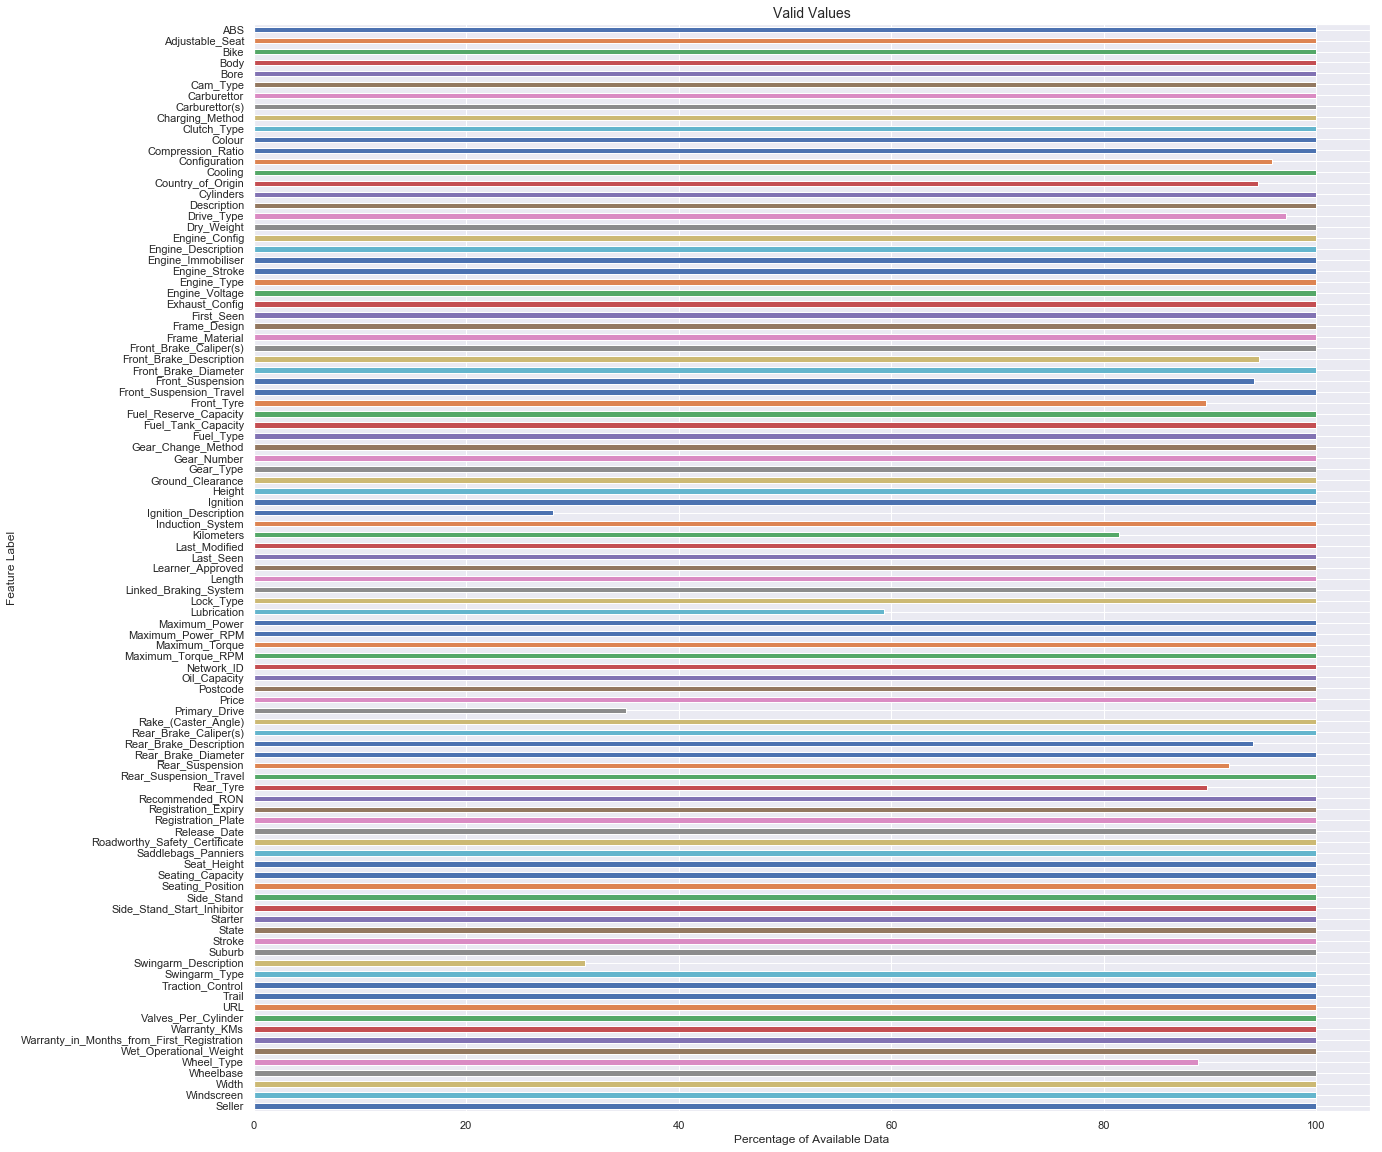

3.38% of data is missing 


In [673]:
missing_bar(test)


# Simplifying Feature Values
We can improve the usefullness of the data by grouping any like values in each feature set, so as to minimse any noise in the feature.



In [1328]:
# I will try to impute the missing values of the following features, but I will have to reduce the number of unique 
# values in some features.
#randomforest_impute = ['Bore','Cam_Type','Carburettor','Charging_Method','Clutch_Type','Cooling',
#                       'Country_of_Origin','Dry_Weight', 'Front_Brake_Caliper(s)','Seating_Position']

group_then_impute = ['Carburettor','Clutch_Type','Configuration','Drive_Type','Frame_Design','Frame_Material',
                     'Front_Brake_Description','Front_Suspension','Ignition_Description',
                     'Primary_Drive','Rear_Brake_Description','Rear_Suspension',
                     'Swingarm_Description','Wheel_Type','Lubrication'
    
]

random_forest = ['Body','Kilometers'
    
]


In [ ]:
idx = (df['Bike'][df['Body'].isnull() == True].str.contains('Competition') == True).index
df['Body'].iloc[idx] = 'Competition'

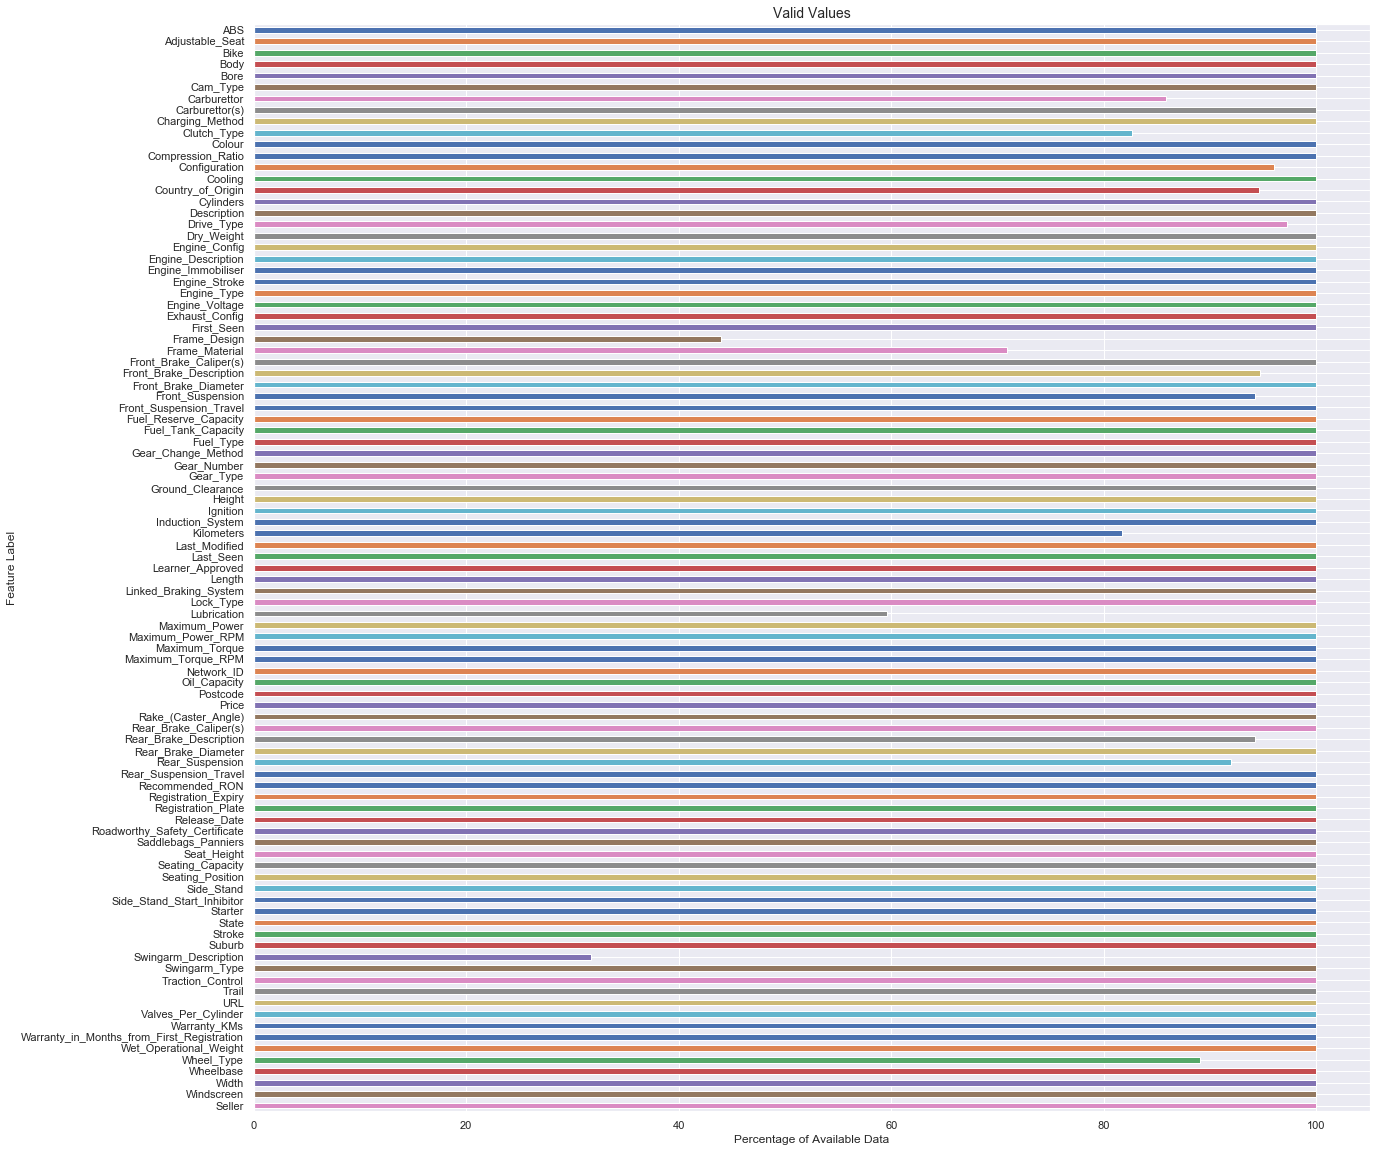

3.069% of data is missing 


In [1187]:
missing_bar(df)

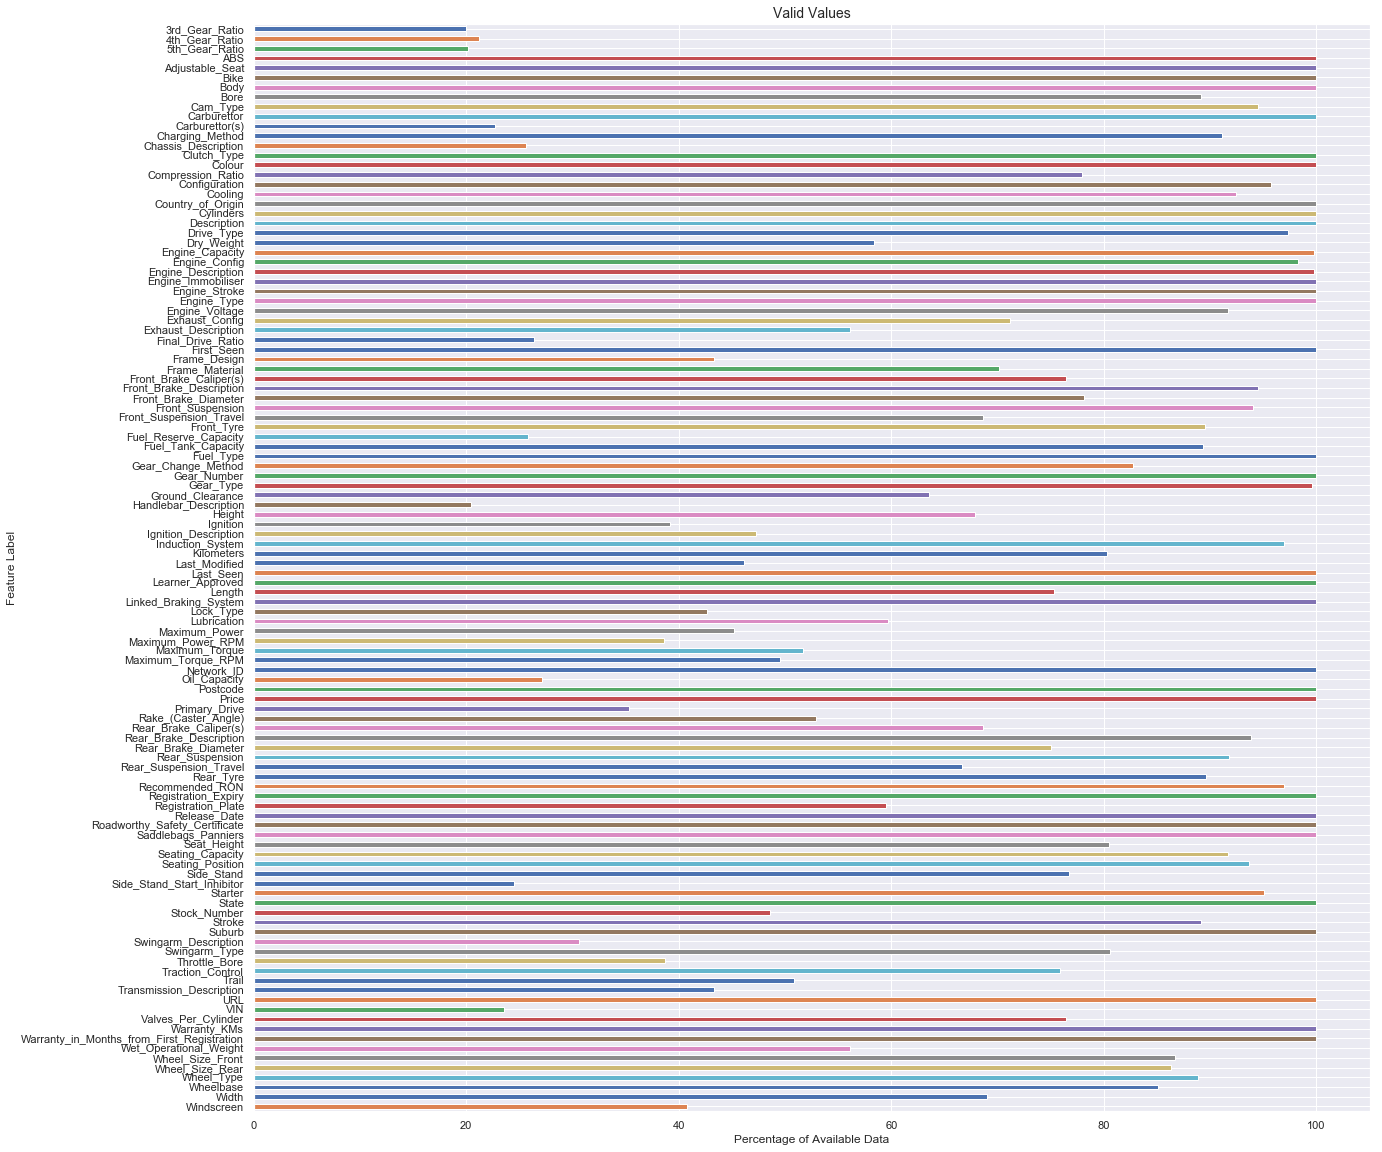

24.326% of data is missing 


In [1332]:
missing_bar(df)


In [1333]:
df.head()


,3rd_Gear_Ratio,4th_Gear_Ratio,5th_Gear_Ratio,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,...,Valves_Per_Cylinder,Warranty_KMs,Warranty_in_Months_from_First_Registration,Wet_Operational_Weight,Wheel_Size_Front,Wheel_Size_Rear,Wheel_Type,Wheelbase,Width,Windscreen
0,NaN,NaN,NaN,No,No,Kuda Pro 250,Adventure Touring,62.0,SOHC (Single Over Head Cam),none,...,NaN,No,3,150.0,"1.60x21""","1.85x18""","Chrome rim, Heavy duty Spokes, Alloy Hub",1480.0,860.0,NaN
1,NaN,NaN,NaN,No,No,250 R Road Manual 5sp 250cc (Discontinued),Super Sport,77.0,SOHC (Single Over Head Cam),none,...,4.0,No,0,136.0,"2.75x17""","3.5x17""","Black, T9 Aluminium rims, 5-star spoke",1350.0,NaN,Standard
2,NaN,NaN,NaN,No,No,GN250 (Jan),Naked,72.0,SOHC (Single Over Head Cam),none,...,NaN,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,No,No,GSX1100 ESD Road Manual 5sp 1100cc (Half fairing),Sport Touring,NaN,DOHC (Double Over Head Cam),constant velocity,...,NaN,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,No,No,TS250 Trail Manual 5sp 250cc,Trail,NaN,Reed Valve,none,...,NaN,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
